In [1]:
import numpy as np # For numerical fast numerical calculations
import matplotlib.pyplot as plt # For making plots
import pandas as pd # Deals with data
import seaborn as sns # Makes beautiful plots
from sklearn.preprocessing import StandardScaler # Testing sklearn
from sklearn.ensemble import RandomForestClassifier, VotingClassifier # Ensembling and voting classifier
from sklearn.feature_extraction.text import TfidfVectorizer # Feature selection through TFIDF vectorizer
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score) # Metrices
from sklearn.model_selection import (GridSearchCV, KFold, RandomizedSearchCV,
                                     learning_curve) # Model selection module
from sklearn.naive_bayes import MultinomialNB # Naive Bayes
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from nltk.corpus import stopwords

In [2]:
def read_preprocess_dataset(file_path):
    """Function to read the dataset with .tsv extension.
    
    Parameters:
    -----------
    file_path: string
        Contains the path to the file to be read.
    
    Returns:
    --------
    dataset: pandas dataframe
        Contains the dataset read.
    """
    dataset = pd.read_csv(file_path, sep='\t', header=None)
    columns_to_select = [1, 2]
    dataset = dataset.iloc[:, columns_to_select]
    dataset.columns = ['label', 'news']

    # Converting the multiclass labels to binary labels
    labels_map = {
        'true': 'true',
        'mostly-true': 'true',
        'half-true': 'true',
        'false': 'false',
        'barely-true': 'false',
        'pants-fire': 'false'
    }
    dataset['label'] = dataset['label'].map(labels_map)
    dataset['news'] = dataset['news'].str.lower()

    return dataset

In [3]:
def check_data_quality(dataset, dataset_name):
    """Function to check the quality of the dataset i.e. if there are 
    missing values and cleaning them by removing those entries.
    Parameters:
    -----------
    dataset: pandas dataframe
        Dataset whose quality is to be checked.
    dataset_name: string 
        Name of the dataset.
    """
    print('Checking the quality of {}'.format(dataset_name))
    print(dataset.isnull().sum())
    print()
    number_of_nulls = dataset.isnull().sum().sum()
    if number_of_nulls > 0:
        dataset.dropna()
    

In [4]:
raw_train_ds = read_preprocess_dataset("/home/coderpriya/DataScienceWorks/projects/fakenewsdetections/Fake-News-Detection-System/datasets/train.tsv")

In [5]:
raw_train_ds.head()

,label,news
0,false,says the annies list political group supports ...
1,false,when did the decline of coal start? it started...
2,true,"hillary clinton agrees with john mccain ""by vo..."
3,false,health care reform legislation is likely to ma...
4,false,the economic turnaround started at the end of ...


In [6]:
raw_validation_ds = read_preprocess_dataset("/home/coderpriya/DataScienceWorks/projects/fakenewsdetections/Fake-News-Detection-System/datasets/valid.tsv")

In [7]:
raw_validation_ds.head()

,label,news
0,false,we have less americans working now than in the...
1,false,"when obama was sworn into office, he did not u..."
2,false,says having organizations parading as being so...
3,false,says nearly half of oregons children are poor.
4,false,on attacks by republicans that various program...


In [8]:
raw_test_ds = read_preprocess_dataset("/home/coderpriya/DataScienceWorks/projects/fakenewsdetections/Fake-News-Detection-System/datasets/test.tsv")

In [9]:
raw_test_ds.head()

,label,news
0,true,building a wall on the u.s.-mexico border will...
1,false,wisconsin is on pace to double the number of l...
2,false,says john mccain has done nothing to help the ...
3,false,suzanne bonamici supports a plan that will cut...
4,false,when asked by a reporter whether hes at the ce...


In [10]:
stopwords_list = list(stopwords.words('english'))

In [11]:
print('Train dataset size: {}'.format(raw_train_ds.shape))
print('Validation dataset size: {}'.format(raw_validation_ds.shape))
print('Test dataset size: {}'.format(raw_test_ds.shape))

Train dataset size: (10240, 2)
Validation dataset size: (1284, 2)
Test dataset size: (1267, 2)


In [12]:
news_df = pd.concat([raw_train_ds, raw_validation_ds], ignore_index=True)
print('Training set size: {}'.format(news_df.shape))

Training set size: (11524, 2)


In [13]:
import string
news_df.news.str.contains('['+string.punctuation+']').sum()


11364

In [14]:
print(news_df.label.value_counts(), '\n')
display(news_df.head())

false    7466
true     4058
Name: label, dtype: int64 



,label,news
0,false,says the annies list political group supports ...
1,false,when did the decline of coal start? it started...
2,true,"hillary clinton agrees with john mccain ""by vo..."
3,false,health care reform legislation is likely to ma...
4,false,the economic turnaround started at the end of ...


In [15]:
news_df.dtypes

label    object
news     object
dtype: object

Using TensorFlow backend.


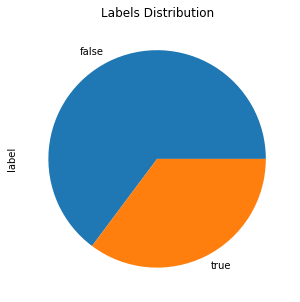



Classes:  ['false' 'true']

Number of One Hot encoded class labels:  2


In [16]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, Normalizer, normalize, scale, FunctionTransformer
from keras.utils import to_categorical, plot_model
train = news_df.news
label = news_df.label

# Plot of label types numbers
pd.Series(label).value_counts().plot(
    kind='pie', title='Labels Distribution', figsize=(5, 5))
plt.show()

# Encode labels and create classes
le = LabelEncoder()
le.fit(label)
label_encoded = le.transform(label)
print("\n\nClasses: ", le.classes_)

# Convert labels into categorical values
label_onehot = to_categorical(label_encoded)
print("\nNumber of One Hot encoded class labels: ", label_onehot.shape[1])

In [17]:
from sklearn.model_selection import train_test_split, StratifiedKFold

%time

SEED = 21

# Splitting data into train, test & validation sets
x_train, x_val_test, y_train, y_val_test = train_test_split(
    train, label_encoded, test_size=.4, stratify=label_encoded, random_state=SEED)

x_val, x_test, y_val, y_test = train_test_split(
    x_val_test, y_val_test, test_size=.6, stratify=y_val_test, random_state=SEED)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.29 µs


In [18]:
# Quantifying the positive & negative sentiments in the dataset

from collections import Counter

counter = Counter(y_train)
print('Train set entries.')
for key in counter:
    if key == 0:
        print('{:.2f}% Fake Entries'.format((counter[key]/len(y_train))*100))
    elif key == 1:
        print('{:.2f}% True Entries'.format((counter[key]/len(y_train))*100))

counter = Counter(y_val)
print('\nValidation set entries.')
for key in counter:
    if key == 0:
        print('{:.2f}% Fake Entries'.format((counter[key]/len(y_val))*100))
    elif key == 1:
        print('{:.2f}% True Entries'.format((counter[key]/len(y_val))*100))

counter = Counter(y_test)
print('\nTest set entries.')
for key in counter:
    if key == 0:
        print('{:.2f}% Fake Entries'.format((counter[key]/len(y_test))*100))
    elif key == 1:
        print('{:.2f}% True Entries'.format((counter[key]/len(y_test))*100))

Train set entries.
64.78% Fake Entries
35.22% True Entries

Validation set entries.
64.80% Fake Entries
35.20% True Entries

Test set entries.
35.21% True Entries
64.79% Fake Entries


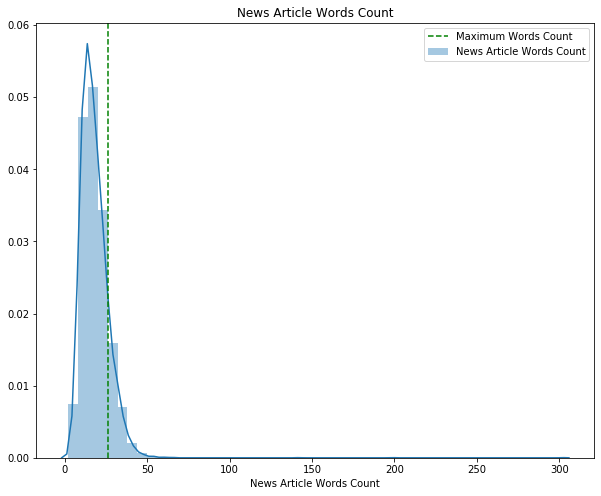

In [19]:
# Visualize words count distribution

news_df['news_len'] = news_df['news'].apply(
    lambda words: len(words.split(" ")))

# Maximum words count in an article, Calculated after averaging & adding standard deviation
max_word_count = np.round(
    news_df['news_len'].mean() + news_df['news_len'].std()).astype(int)

plt.figure(figsize=(10, 8))

sns.distplot(news_df['news_len'], hist=True, kde=True,
             label='News Article Words Count')

plt.axvline(x=max_word_count, color='green',
            linestyle='--', label='Maximum Words Count')
plt.title('News Article Words Count')
plt.xlabel('News Article Words Count')
plt.legend()
plt.show()

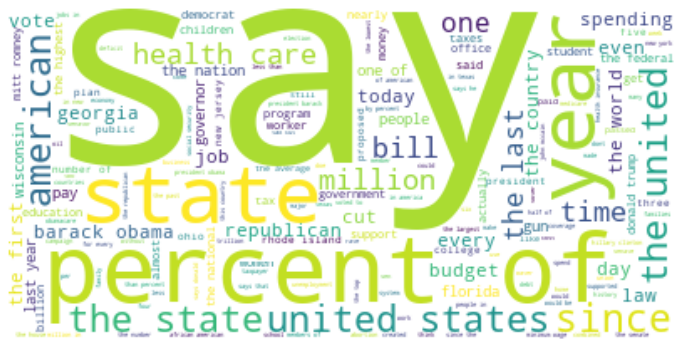

In [20]:
# Wordcloud beautification for True news
from wordcloud import WordCloud

true_word_tokens = pd.Series(
    news_df[news_df['label'] == 'true'].news.tolist()).str.cat(sep=' ')

wordcloud = WordCloud(max_font_size=200, stopwords=stopwords.words(
    'english'), random_state=None, background_color='white').generate(true_word_tokens)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

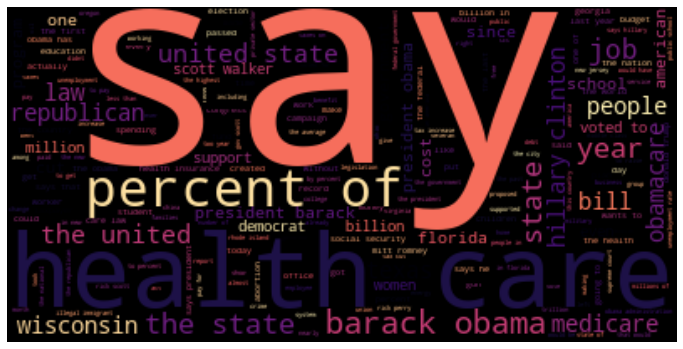

In [21]:
# Wordcloud beautification for Fake news

fake_word_tokens = pd.Series(
    news_df[news_df['label'] == 'false'].news.tolist()).str.cat(sep=' ')

wordcloud = WordCloud(max_font_size=200, stopwords=stopwords.words(
    'english'), random_state=None, background_color='black', colormap='magma').generate(fake_word_tokens)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [22]:
import nltk
nltk.download('stopwords')
# TfidfVectorizer Maximum nuber of features

max_features = 3000

# tf-idf vectorizer for sentence/topic/document modelling

tvec = TfidfVectorizer(max_features=max_features, ngram_range=(1, 3), max_df=0.65,
                       tokenizer=nltk.word_tokenize,
                       strip_accents='unicode',
                       lowercase=True, analyzer='word',
                       use_idf=True, smooth_idf=True, sublinear_tf=False,
                       stop_words=stopwords.words('english'))


# Fit & Transform on train texts
# Only transform on val & test texts

x_train_tf = tvec.fit_transform(x_train).toarray()
x_val_tf = tvec.transform(x_val).toarray()
x_test_tf = tvec.transform(x_test).toarray()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/coderpriya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/coderpriya/anaconda3/envs/PythonCPU/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [23]:
from sklearn.feature_selection import SelectKBest, chi2

# Fitting Chi2

chi2score = chi2(x_train_tf, y_train)[0]

print('chi2score.size: ', chi2score.size)

print('\nDumping chi2score ...')
#joblib.dump(chi2score, os.path.join('./save/pickle', 'chi2score.pickle'))

chi2score.size:  3000

Dumping chi2score ...


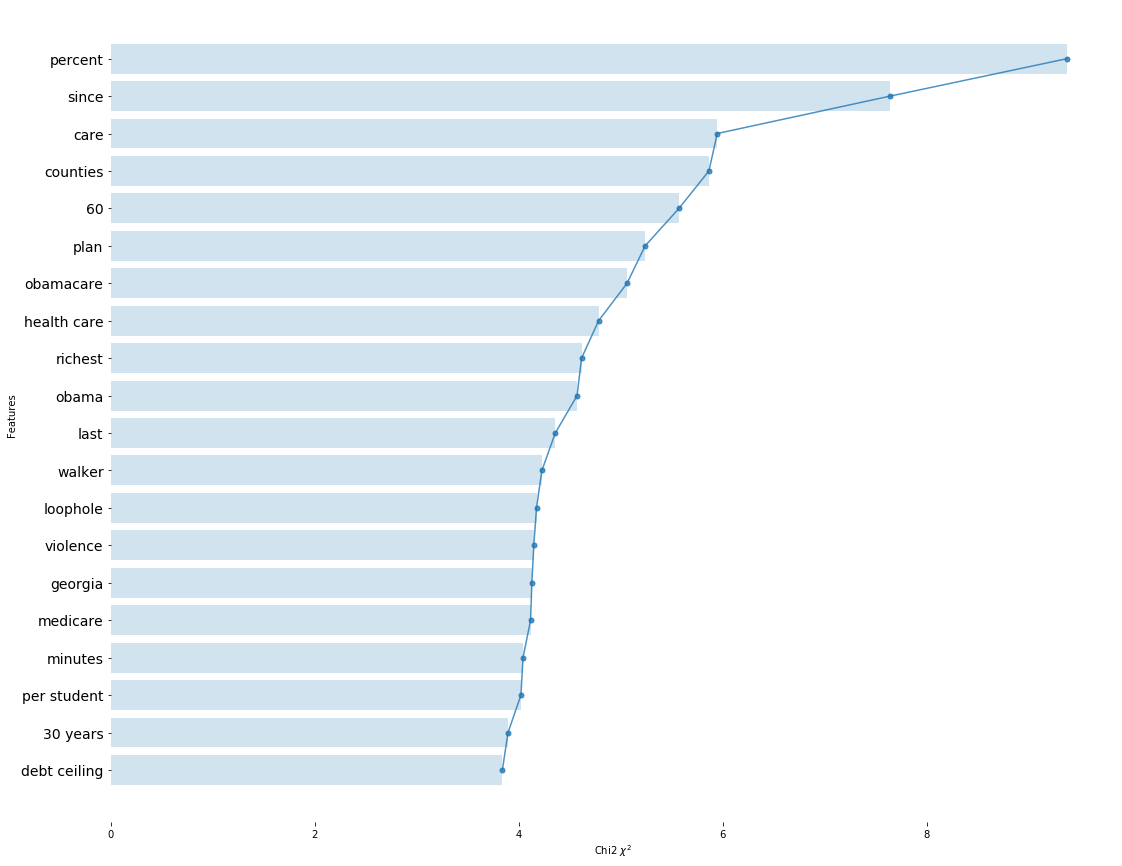

In [24]:
# Plot Important chi2square features after reducing dimesions

ax = plt.figure(figsize=(18, 15))

# Zip features names alongwith their scores & sort by chi2 score
features_chi2scores = zip(tvec.get_feature_names(), chi2score)
features_chi2scores_sorted = sorted(features_chi2scores, key=lambda x: x[1])

# Top 20 Chi2 features
topchi2 = list(zip(*features_chi2scores_sorted[-20:]))

# Feature name & total length of the features to plot a horizontal barplot
feature_names = topchi2[0]
feature_score = topchi2[1]
features_len = range(len(feature_score))

plt.barh(features_len, feature_score, align='center', alpha=0.2)
plt.plot(feature_score, features_len, '-o', markersize=5, alpha=0.8)

plt.yticks(features_len, feature_names, fontsize=14)

plt.xlabel('Chi2 $\chi^2$')
plt.ylabel('Features')

for spine in plt.gca().spines.values():
    spine.set_visible(False)

In [25]:
# Dimension reduction & testing on valdiation set

ch2_result = []

for features in np.arange(50, max_features, 100):

    # Select best features
    ch2 = SelectKBest(chi2, k=features)

    x_train_chi2_selected = ch2.fit_transform(x_train_tf, y_train)
    x_val_chi2_selected = ch2.transform(x_val_tf)

    # Fitting Logistic Regression classical model
    clf = LogisticRegression()
    clf.fit(x_train_chi2_selected, y_train)

    # Testing on the validation set
    score = clf.score(x_val_chi2_selected, y_val)

    print('Evaluation done for {} features using Chi2 feature selection method.'.format(features))

    print('Validation Score: ', np.round(score*100, 2))
    ch2_result.append(score)

Evaluation done for 50 features using Chi2 feature selection method.
Validation Score:  63.34
Evaluation done for 150 features using Chi2 feature selection method.
Validation Score:  63.88
Evaluation done for 250 features using Chi2 feature selection method.
Validation Score:  64.15
Evaluation done for 350 features using Chi2 feature selection method.
Validation Score:  64.86
Evaluation done for 450 features using Chi2 feature selection method.
Validation Score:  65.24
Evaluation done for 550 features using Chi2 feature selection method.
Validation Score:  64.91
Evaluation done for 650 features using Chi2 feature selection method.
Validation Score:  64.91
Evaluation done for 750 features using Chi2 feature selection method.
Validation Score:  65.18
Evaluation done for 850 features using Chi2 feature selection method.
Validation Score:  64.91
Evaluation done for 950 features using Chi2 feature selection method.
Validation Score:  65.13
Evaluation done for 1050 features using Chi2 featur

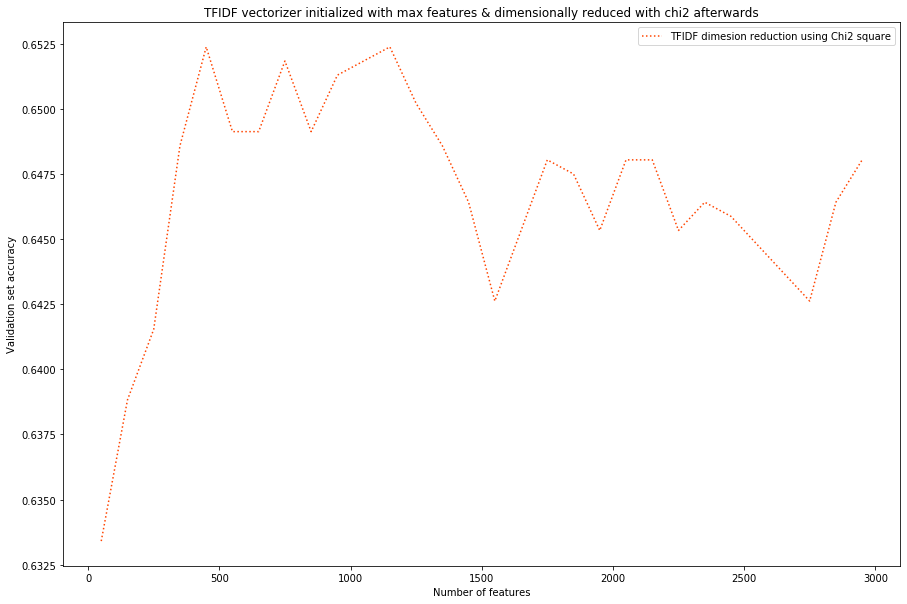

In [26]:
#Plot Important chi2square features after reducing dimesions

plt.figure(figsize=(15, 10))

plt.plot(np.arange(50, max_features, 100), ch2_result,
         label='TFIDF dimesion reduction using Chi2 square', linestyle=':', color='orangered')

plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")

plt.title("TFIDF vectorizer initialized with max features & dimensionally reduced with chi2 afterwards")
plt.legend()

In [27]:
# Scale using Standard Scaler

scaler = StandardScaler()
x_train_tf_scaled = scaler.fit_transform(x_train_tf)

In [28]:
from sklearn.decomposition import PCA

# PCA Decomposition

pca = PCA().fit(x_train_tf_scaled)


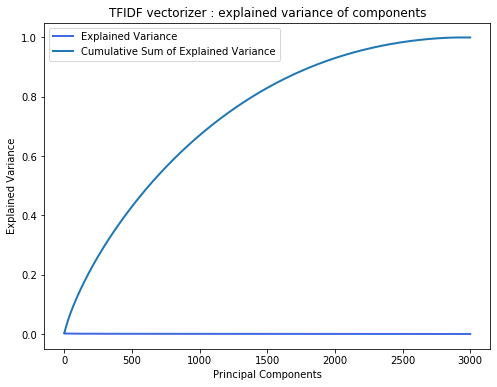

In [29]:
# Plot PCA on 2D

fig, ax = plt.subplots(figsize=(8, 6))

pca_components = range(1, pca.n_components_+1)
# pca_components = range(1, len(pca.explained_variance_ratio_)+1)

ax.plot(pca_components, pca.explained_variance_ratio_,
        lw=2, color='royalblue', label='Explained Variance')
ax.plot(pca_components, np.cumsum(pca.explained_variance_ratio_),
        lw=2, label='Cumulative Sum of Explained Variance')

# ax.set_xlim(-1, 300)
ax.set_xlabel('Principal Components')
ax.set_ylabel('Explained Variance')
ax.set_title('TFIDF vectorizer : explained variance of components')

plt.legend()
plt.show()

In [30]:
# Plot English FastText embeddings with t-SNE


def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):

    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"

    plt.figure(figsize=(18, 18))  # in inches

    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label, fontsize=10, xy=(x, y), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom')

    #plt.savefig(os.path.join('./save', filename))
    plt.show()

In [31]:
from sklearn.feature_extraction.text import CountVectorizer # Feature selection through count vectorizer
cvec = CountVectorizer(stop_words=stopwords.words(
    'english'), ngram_range=(1, 3))
cvec.fit(news_df.news)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 3), preprocessor=None,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [32]:
cvec_features = cvec.get_feature_names()
len(cvec_features)

192244

In [33]:
# Calculating positive, negative matrices and summing along rows

fake_matrix = cvec.transform(news_df[news_df['label'] == 'false'].news)
true_matrix = cvec.transform(news_df[news_df['label'] == 'true'].news)

# Summing tf-idf values
fake_tf = np.sum(fake_matrix, axis=0)
true_tf = np.sum(true_matrix, axis=0)

# Remove single-dimensional entries from the shape of an array.
fake_tf_sq = np.squeeze(np.asarray(fake_tf))
true_tf_sq = np.squeeze(np.asarray(true_tf))

# tf-idf values saved in the dataframe
news_tfidf = pd.DataFrame([fake_tf_sq, true_tf_sq],
                          columns=cvec.get_feature_names()).transpose()
#news_tfidf.to_hdf('./data/news_tfidf.hdf', 'News-TFIDF')


In [34]:
from IPython.display import display, HTML

display(news_tfidf.head())

,0,1
00,2,1
00 2014,1,0
00 2014 due,1,0
00 per,1,0
00 per month,1,0


In [35]:
# Sorting positive, negative sentiments

news_tfidf.columns = ['fake', 'true']
news_tfidf['total'] = news_tfidf['fake'] + news_tfidf['true']

#news_tfidf.to_csv('./data/news_tfidf.csv', encoding='utf-8')
news_tfidf.sort_values(by='total', ascending=False).iloc[:10]

,fake,true,total
says,1852,815,2667
percent,726,617,1343
state,579,383,962
obama,640,204,844
000,507,315,822
tax,485,277,762
health,520,199,719
year,419,279,698
years,404,280,684
president,494,184,678


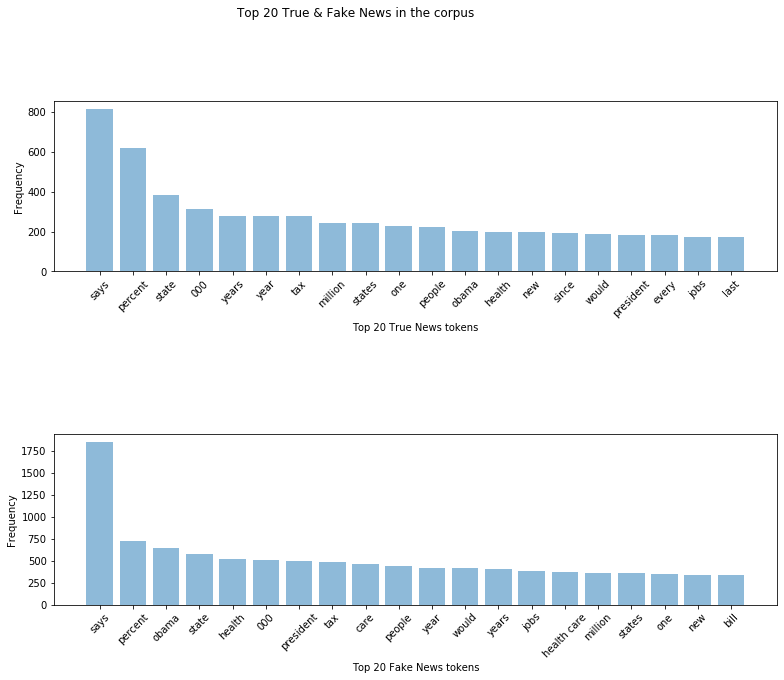

In [36]:
# Top 50 words

twenty_words = np.arange(20)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle('Top 20 True & Fake News in the corpus')

ax1.bar(twenty_words, news_tfidf.sort_values(by='true', ascending=False)[
        'true'][:20], align='center', alpha=0.5)
ax1.set_xlabel('Top 20 True News tokens')
ax1.set_ylabel('Frequency')
ax1.set_xticks(twenty_words)
ax1.set_xticklabels(news_tfidf.sort_values(by='true', ascending=False)[
                    'true'][:20].index, rotation=45)

ax2.bar(twenty_words, news_tfidf.sort_values(by='fake', ascending=False)[
        'fake'][:20], align='center', alpha=0.5)
ax2.set_xlabel('Top 20 Fake News tokens')
ax2.set_ylabel('Frequency')
ax2.set_xticks(twenty_words)
ax2.set_xticklabels(news_tfidf.sort_values(by='fake', ascending=False)[
                    'fake'][:20].index, rotation=45)

plt.tight_layout()
plt.subplots_adjust(top=0.85, bottom=0.15, left=0.15, wspace=0.15, hspace=.95)
plt.show()

Text(0.5, 1.0, 'Fake vs True News tokens Frequency')

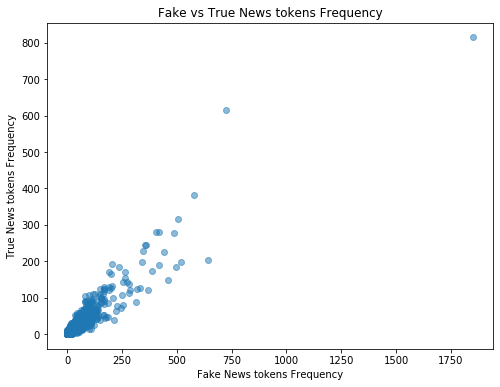

In [37]:
# Plot Fake & True News keyword frequency on X-axis, Y-axis respectively

plt.figure(figsize=(8, 6))
ax = sns.regplot(x="fake", y="true", fit_reg=False,
                 scatter_kws={'alpha': 0.5}, data=news_tfidf)

plt.xlabel('Fake News tokens Frequency')
plt.ylabel('True News tokens Frequency')

plt.title('Fake vs True News tokens Frequency')


In [38]:
# Top 10 words in tf-idf
my_stop_words = frozenset(list(news_tfidf.sort_values(
    by='total', ascending=False).iloc[:10].index))

# Check top 10 words in tf-idf are present in english stop words
set(my_stop_words).issubset(set(stopwords.words('english')))

False

In [39]:
# Defining adjusted_classes function & plotting precision_recall curve with a given threshold


def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """

    return [1 if y >= t else 0 for y in y_scores]


def precision_recall_threshold(precision, recall, thresholds, y_test, y_scores, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """

    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.

    print('\n Plotting precision_recall curve against a given threshold of {}'.format(t))
    y_pred_adj = adjusted_classes(y_scores, t)
    print('\n\nAdjusted Threshold Confusion Matrix\n\n', pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                                                                      columns=[
                                                                          'pred_neg', 'pred_pos'],
                                                                      index=['neg', 'pos']), '\n\n')

    print('\n\nAdjusted Threshold F1 Score: ',
          f1_score(y_test, y_pred_adj, average=None))

    # plot the curve
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    # plt.ylim([0.5, 1.01]);
    # plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(recall[close_default_clf], precision[close_default_clf], '^', c='k',
             markersize=15)


# Plotting precision_recall vs decision threshold curve

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):

    plt.figure(figsize=(8, 8))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

    plt.xlabel("Decision Threshold")
    plt.ylabel("Score")
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.legend(loc='best')


# Plot an ROC-AUC curve

def plot_roc_curve(fpr, tpr, label=None):

    plt.figure(figsize=(8, 8))

    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')

    plt.xticks(np.arange(0, 1, 0.25), rotation=45)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title('ROC Curve')
    plt.legend(loc='best')


# Plot the confusion matrix

def plot_confusion_matrix(cm,
                          target_names,
                          plt_name,
                          rootdir='./',
                          save_dir='save/',
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    plot_confusion_matrix function prints & plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    :param cm:confusion matrix from sklearn.metrics.confusion_matrix
    :param target_names:classification classes list eg. [0, 1] ['high', 'medium', 'low']
    :param rootdir:str
    :param save_dir:str
    :param plt_name:str
    :param title:str
    :param cmap:color map list
    :param normalize:bool
    :return:
    """

    plt_name += '_ConfusionMatrix'
    if normalize:
        plt_name = '{}_Normalized'.format(plt_name)

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n\nAccuracy={:0.4f}; Misclassified={:0.4f}'.format(
        accuracy, misclass))

    print('\n\nSaving Confusion Matrices in the {} directory'.format(
        rootdir + save_dir))
    #plt.savefig(rootdir + save_dir + '/{}.png'.format(plt_name), dpi=200, format='png', bbox_inches='tight')

    plt.show()
    plt.close()

In [40]:
# Calculates different metrics & summmary of different set of features


def metrics_fusion(pipeline, x_train, y_train, x_test, y_test, model_trained=False, stats=False, precision_recall_stats=False, new_threshold=0.5):

    # Timer starts
    timer = datetime.now()

    if not model_trained:
        pipeline.fit(x_train, y_train)

    y_pred = pipeline.predict(x_test)
    y_pred = np.array([int(np.round(value)) for value in y_pred])

    # Store the predictions probability
    predictions_prob = pipeline.predict_proba(x_test)[:,1]

    elapsed_time = datetime.now() - timer
    # Timer stops

    # Accuracy score
    accuracy = accuracy_score(y_test, y_pred)

    print('\nAccuracy score: {:.2f}%'.format(accuracy*100))
    print('Overall Train and Prediction time: {:.2f}s'.format(
        elapsed_time.total_seconds()))
    print('-'*89)

    # Confusion matrix
    con_matrix = confusion_matrix(y_test, y_pred)

    print('\n\nConfusion matrix of the Fake News test set\n\n')
    display(pd.DataFrame(con_matrix, columns=list(
        le.classes_), index=list(le.classes_)))

    classi_report = []
    if stats:
        # Plot the confusion matrix
        plot_confusion_matrix(con_matrix,
                              target_names=list(le.classes_),
                              plt_name='FakeNews_FastText_Matrix',
                              rootdir='./',
                              save_dir='save/con_matrix',
                              title='Confusion matrix',
                              cmap=plt.cm.Blues,
                              normalize=False)

        classi_report = classification_report(
            y_test, y_pred, target_names=list(le.classes_))
        print('\nClassification Report\n\n{}'.format(classi_report))

    if precision_recall_stats:
        # Generate the precision-recall curve for the classifier
        precision, recall, thresholds = precision_recall_curve(
            y_test, predictions_prob)

        # Plotting precision_recall vs decision threshold curve
        plot_precision_recall_vs_threshold(precision, recall, thresholds)

        # Plot precision_recall curve with a given threshold
        precision_recall_threshold(
            precision, recall, thresholds, y_test, predictions_prob, t=new_threshold)

        # Calculate False Positive rate, True Positive Rate, AUC Thresholds
        fpr, tpr, auc_thresholds = roc_curve(y_test, predictions_prob)

        # Plot ROC-AUC curve
        plot_roc_curve(fpr, tpr, 'Area Under Curve: {}'.format(auc(fpr, tpr)))

    return accuracy, elapsed_time, con_matrix, classi_report

In [41]:
# Feature extraction, Iteratively

# Count Vectorizer, Logistic Regression model
cvec = CountVectorizer()
lr = LogisticRegression()

n_features = np.arange(10000, 80000, 10000)


def feature_extraction(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr, stats=False):
    result = []
    print(classifier)

    for features in n_features:
        # Setting vectorizer parameters & creating pipeline
        cvec.set_params(stop_words=stop_words,
                        max_features=features, ngram_range=ngram_range)
        pipeline = Pipeline([
            ('vectorizer', cvec),
            ('classifier', classifier)
        ])
        print("\nValidation result for {} features".format(features))

        # Calculate accuracy & summmary
        features_accuracy, features_time, _, _ = metrics_fusion(
            pipeline, x_train, y_train, x_val, y_val, stats=stats)
        result.append((features, features_accuracy, features_time))

    return result

In [42]:
%time
from datetime import datetime
from time import time
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix, classification_report, log_loss, auc, roc_auc_score, roc_curve, f1_score, precision_recall_curve, recall_score, precision_score

print('Result for Trigram Without English STOP words\n')
feature_trigram_nostop = feature_extraction(ngram_range=(1, 3), stats=False)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs
Result for Trigram Without English STOP words

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Validation result for 10000 features

Accuracy score: 62.96%
Overall Train and Prediction time: 1.13s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




/home/coderpriya/anaconda3/envs/PythonCPU/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,false,true
false,920,275
true,408,241



Validation result for 20000 features

Accuracy score: 64.53%
Overall Train and Prediction time: 1.29s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




/home/coderpriya/anaconda3/envs/PythonCPU/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,false,true
false,957,238
true,416,233



Validation result for 30000 features

Accuracy score: 64.05%
Overall Train and Prediction time: 1.42s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




/home/coderpriya/anaconda3/envs/PythonCPU/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,false,true
false,957,238
true,425,224



Validation result for 40000 features


/home/coderpriya/anaconda3/envs/PythonCPU/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



Accuracy score: 63.83%
Overall Train and Prediction time: 1.71s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




,false,true
false,961,234
true,433,216



Validation result for 50000 features

Accuracy score: 64.10%
Overall Train and Prediction time: 1.61s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




/home/coderpriya/anaconda3/envs/PythonCPU/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,false,true
false,966,229
true,433,216



Validation result for 60000 features

Accuracy score: 64.97%
Overall Train and Prediction time: 1.75s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




/home/coderpriya/anaconda3/envs/PythonCPU/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,false,true
false,980,215
true,431,218



Validation result for 70000 features

Accuracy score: 64.10%
Overall Train and Prediction time: 1.92s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




/home/coderpriya/anaconda3/envs/PythonCPU/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,false,true
false,972,223
true,439,210


In [43]:
%time

print('Result for Trigram with English STOP words\n')
feature_trigram_stop = feature_extraction(ngram_range=(
    1, 3), stop_words=stopwords.words('english'), stats=False)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.29 µs
Result for Trigram with English STOP words

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Validation result for 10000 features

Accuracy score: 62.58%
Overall Train and Prediction time: 0.87s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




,false,true
false,943,252
true,438,211



Validation result for 20000 features

Accuracy score: 62.96%
Overall Train and Prediction time: 0.99s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




,false,true
false,955,240
true,443,206



Validation result for 30000 features

Accuracy score: 63.29%
Overall Train and Prediction time: 1.03s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




,false,true
false,965,230
true,447,202



Validation result for 40000 features

Accuracy score: 63.45%
Overall Train and Prediction time: 1.10s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




,false,true
false,975,220
true,454,195



Validation result for 50000 features

Accuracy score: 63.67%
Overall Train and Prediction time: 1.31s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




,false,true
false,983,212
true,458,191



Validation result for 60000 features

Accuracy score: 63.18%
Overall Train and Prediction time: 1.39s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




,false,true
false,980,215
true,464,185



Validation result for 70000 features

Accuracy score: 63.61%
Overall Train and Prediction time: 1.24s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




,false,true
false,993,202
true,469,180


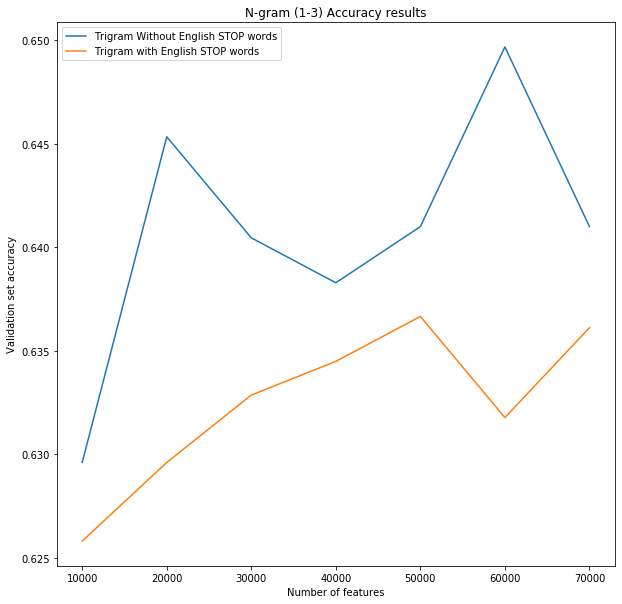

In [44]:
# Dataframes feature extraction results for without stop, with stop & custom stop words

feature_trigram_nostop_df = pd.DataFrame(feature_trigram_nostop, columns=[
                                         'features', 'features_accuracy', 'features_time'])
feature_trigram_stop_df = pd.DataFrame(feature_trigram_stop, columns=[
                                       'features', 'features_accuracy', 'features_time'])

# Plot the results
plt.figure(figsize=(10, 10))

plt.plot(feature_trigram_nostop_df.features, feature_trigram_nostop_df.features_accuracy,
         label='Trigram Without English STOP words')
plt.plot(feature_trigram_stop_df.features,
         feature_trigram_stop_df.features_accuracy, label='Trigram with English STOP words')

plt.title("N-gram (1-3) Accuracy results")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")

plt.legend()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.53 µs

Accuracy score: 62.58%
Overall Train and Prediction time: 0.87s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




,false,true
false,943,252
true,438,211




Saving Confusion Matrices in the ./save/con_matrix directory


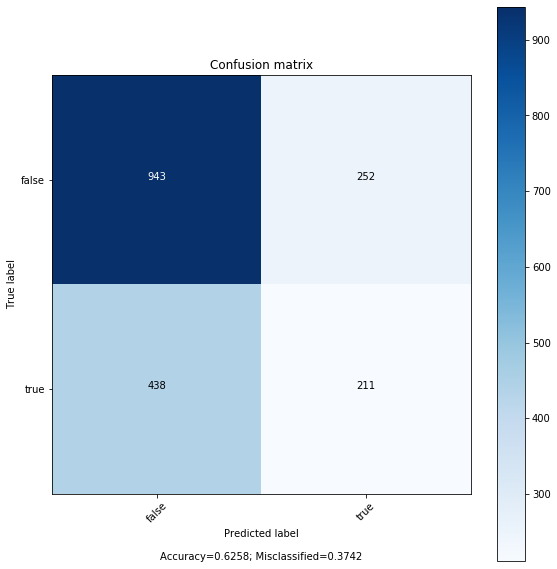


Classification Report

              precision    recall  f1-score   support

       false       0.68      0.79      0.73      1195
        true       0.46      0.33      0.38       649

    accuracy                           0.63      1844
   macro avg       0.57      0.56      0.56      1844
weighted avg       0.60      0.63      0.61      1844


 Plotting precision_recall curve against a given threshold of 0.1


Adjusted Threshold Confusion Matrix

      pred_neg  pred_pos
neg       246       949
pos        75       574 




Adjusted Threshold F1 Score:  [0.32453826 0.52854512]


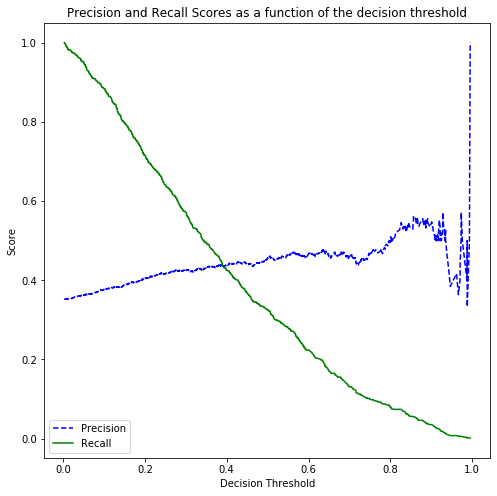

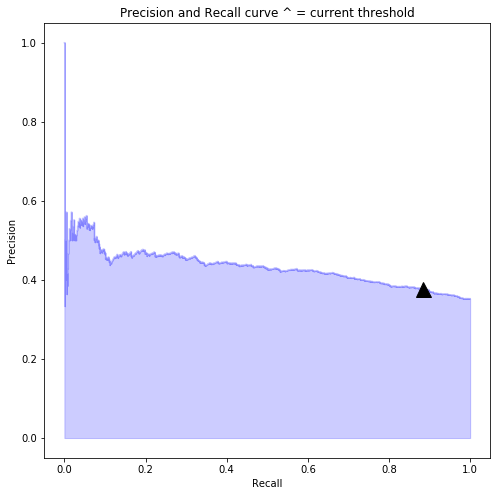

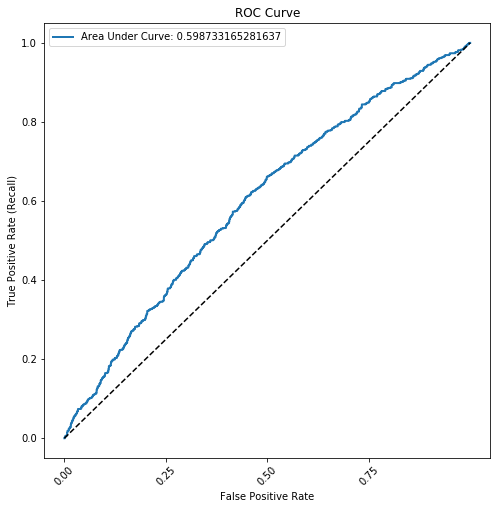

In [45]:
%time
from itertools import product, compress

trigram_cvec = CountVectorizer(
    max_features=10000, stop_words=stopwords.words('english'), ngram_range=(1, 3))
lr = LogisticRegression()

trigram_pipeline = Pipeline([
    ('vectorizer', trigram_cvec),
    ('classifier', lr)
])

# Run trigram feature extraction with updated function
accuracy, elapsed_time, fusion_df, classi_report = metrics_fusion(
    trigram_pipeline, x_train, y_train, x_val, y_val, stats=True, precision_recall_stats=True, new_threshold=0.1)

In [46]:
# Tfidf Vectorizer

tvec = TfidfVectorizer(ngram_range=(1, 3))

In [47]:
%time

print('Result for Trigram Without English STOP words using TF-IDF vectorizer\n')
feature_trigram_nostop_tf = feature_extraction(
    vectorizer=tvec, ngram_range=(1, 3), stats=False)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.25 µs
Result for Trigram Without English STOP words using TF-IDF vectorizer

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Validation result for 10000 features

Accuracy score: 62.96%
Overall Train and Prediction time: 1.21s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




/home/coderpriya/anaconda3/envs/PythonCPU/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,false,true
false,920,275
true,408,241



Validation result for 20000 features

Accuracy score: 64.53%
Overall Train and Prediction time: 1.33s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




/home/coderpriya/anaconda3/envs/PythonCPU/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,false,true
false,957,238
true,416,233



Validation result for 30000 features

Accuracy score: 64.05%
Overall Train and Prediction time: 1.49s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




/home/coderpriya/anaconda3/envs/PythonCPU/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,false,true
false,957,238
true,425,224



Validation result for 40000 features

Accuracy score: 63.83%
Overall Train and Prediction time: 1.58s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




/home/coderpriya/anaconda3/envs/PythonCPU/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,false,true
false,961,234
true,433,216



Validation result for 50000 features

Accuracy score: 64.10%
Overall Train and Prediction time: 1.69s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




/home/coderpriya/anaconda3/envs/PythonCPU/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,false,true
false,966,229
true,433,216



Validation result for 60000 features

Accuracy score: 64.97%
Overall Train and Prediction time: 1.80s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




/home/coderpriya/anaconda3/envs/PythonCPU/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,false,true
false,980,215
true,431,218



Validation result for 70000 features

Accuracy score: 64.10%
Overall Train and Prediction time: 1.88s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




/home/coderpriya/anaconda3/envs/PythonCPU/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,false,true
false,972,223
true,439,210


In [48]:
%time

print('Result for Trigram with English STOP words using TF-IDF vectorizer\n')
feature_trigram_stop_tf = feature_extraction(vectorizer=tvec, ngram_range=(
    1, 3), stop_words=stopwords.words('english'), stats=False)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.53 µs
Result for Trigram with English STOP words using TF-IDF vectorizer

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Validation result for 10000 features

Accuracy score: 62.58%
Overall Train and Prediction time: 0.82s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




,false,true
false,943,252
true,438,211



Validation result for 20000 features

Accuracy score: 62.96%
Overall Train and Prediction time: 0.93s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




,false,true
false,955,240
true,443,206



Validation result for 30000 features

Accuracy score: 63.29%
Overall Train and Prediction time: 1.06s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




,false,true
false,965,230
true,447,202



Validation result for 40000 features

Accuracy score: 63.45%
Overall Train and Prediction time: 1.07s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




,false,true
false,975,220
true,454,195



Validation result for 50000 features

Accuracy score: 63.67%
Overall Train and Prediction time: 1.20s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




,false,true
false,983,212
true,458,191



Validation result for 60000 features

Accuracy score: 63.18%
Overall Train and Prediction time: 1.24s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




,false,true
false,980,215
true,464,185



Validation result for 70000 features

Accuracy score: 63.61%
Overall Train and Prediction time: 1.16s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




,false,true
false,993,202
true,469,180


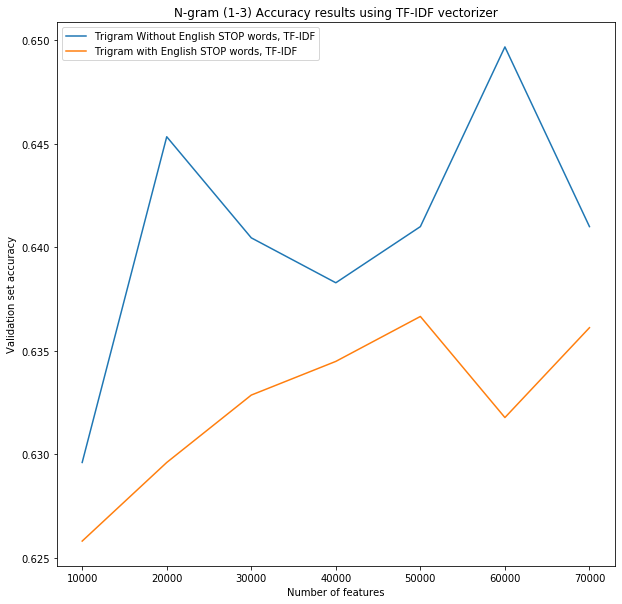

In [49]:
# Dataframes feature extraction results for without stop, with stop & custom stop words

feature_trigram_nostop_tf_df = pd.DataFrame(feature_trigram_nostop_tf, columns=[
                                            'features', 'features_accuracy', 'features_time'])
feature_trigram_stop_tf_df = pd.DataFrame(feature_trigram_stop_tf, columns=[
                                          'features', 'features_accuracy', 'features_time'])

# Plot all results
plt.figure(figsize=(10, 10))

plt.plot(feature_trigram_nostop_tf_df.features, feature_trigram_nostop_tf_df.features_accuracy,
         label='Trigram Without English STOP words, TF-IDF')
plt.plot(feature_trigram_stop_tf_df.features, feature_trigram_stop_tf_df.features_accuracy,
         label='Trigram with English STOP words, TF-IDF')

plt.title("N-gram (1-3) Accuracy results using TF-IDF vectorizer")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")

plt.legend()


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.81 µs

Accuracy score: 65.35%
Overall Train and Prediction time: 0.77s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




,false,true
false,1087,108
true,531,118




Saving Confusion Matrices in the ./save/con_matrix directory


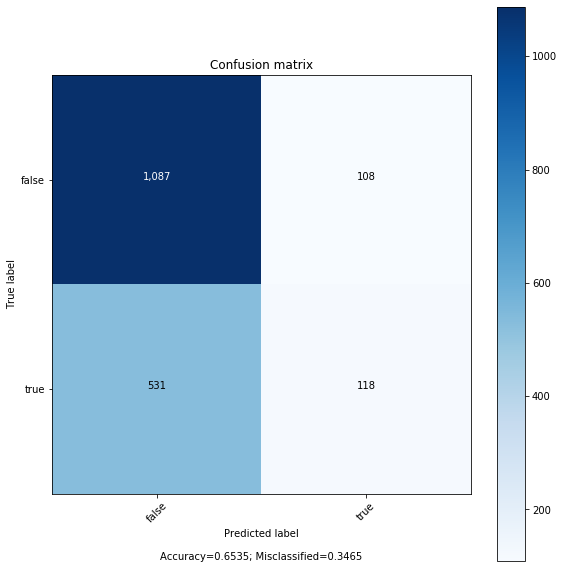


Classification Report

              precision    recall  f1-score   support

       false       0.67      0.91      0.77      1195
        true       0.52      0.18      0.27       649

    accuracy                           0.65      1844
   macro avg       0.60      0.55      0.52      1844
weighted avg       0.62      0.65      0.60      1844


 Plotting precision_recall curve against a given threshold of 0.1


Adjusted Threshold Confusion Matrix

      pred_neg  pred_pos
neg        10      1185
pos         3       646 




Adjusted Threshold F1 Score:  [0.01655629 0.52096774]


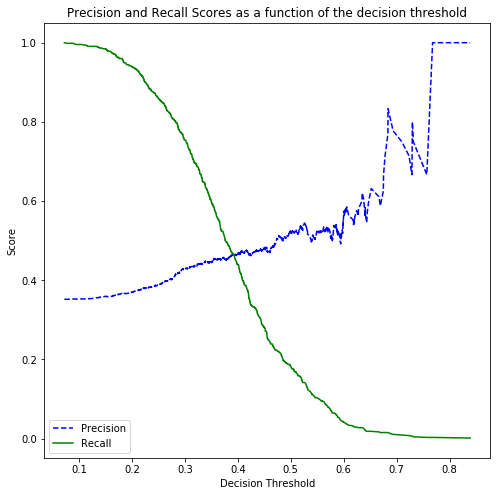

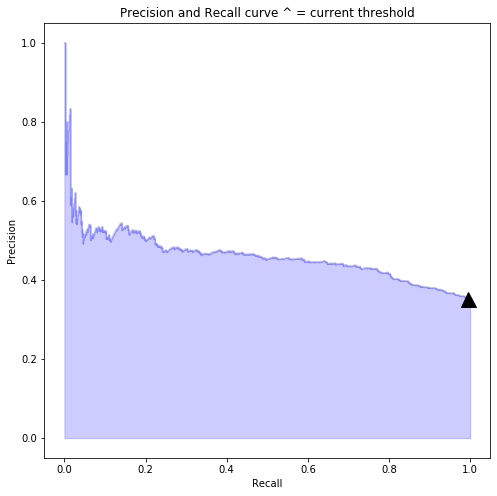

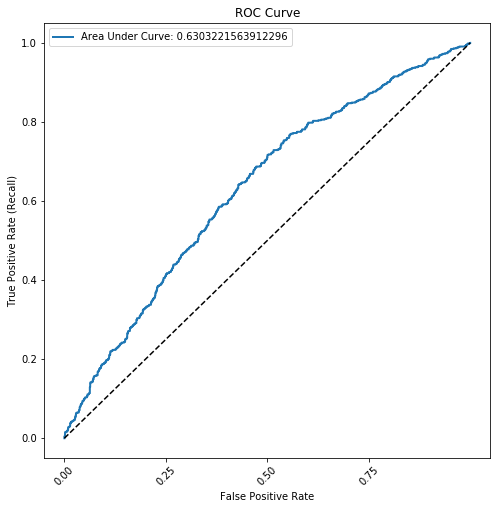

In [50]:
%time

tvec = TfidfVectorizer(max_features=10000, stop_words=stopwords.words(
    'english'), ngram_range=(1, 3))
lr = LogisticRegression()

trigram_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', lr)
])

# Run trigram feature extraction with updated function
accuracy, elapsed_time, fusion_df, classi_report = metrics_fusion(
    trigram_pipeline, x_train, y_train, x_val, y_val, stats=True, precision_recall_stats=True, new_threshold=0.1)

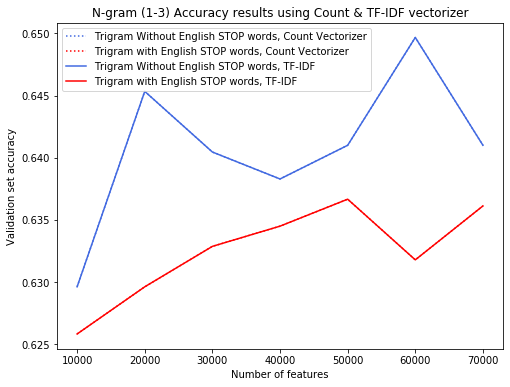

In [51]:
# Plot all results
plt.figure(figsize=(8, 6))

plt.plot(feature_trigram_nostop_df.features, feature_trigram_nostop_df.features_accuracy,
         linestyle=':', color='royalblue', label='Trigram Without English STOP words, Count Vectorizer')
plt.plot(feature_trigram_stop_df.features, feature_trigram_stop_df.features_accuracy,
         linestyle=':', color='red', label='Trigram with English STOP words, Count Vectorizer')

plt.plot(feature_trigram_nostop_tf_df.features, feature_trigram_nostop_tf_df.features_accuracy,
         color='royalblue', label='Trigram Without English STOP words, TF-IDF')
plt.plot(feature_trigram_stop_tf_df.features, feature_trigram_stop_tf_df.features_accuracy,
         color='red', label='Trigram with English STOP words, TF-IDF')

plt.title("N-gram (1-3) Accuracy results using Count & TF-IDF vectorizer")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")

plt.legend()

In [52]:
# Calculate metrices average


def metric_avg(metric_dict):

    # Dataframe containing classifier name & score
    metric_df = pd.DataFrame.from_dict(metric_dict, orient='index')

    #acc_df = acc_df.add_suffix('_Iteration')
    metric_df.columns = [
        str(col+1) + '_Iteration' for col in metric_df.columns]

    # Flatten scores
    metric_df = metric_df.applymap(lambda x: pd.Series(x).mean())

    # Calculate average score
    metric_df['avg'] = metric_df.mean(axis=1)

    metric_df = (metric_df*100).round(2)

    return metric_df

# Plot metrices average


def plot_metrics(sorted_acc_df, sorted_f1_df, sorted_auc_df):

    nb_rows, nb_cols = 1, 3
    fig, axes = plt.subplots(nb_rows, nb_cols, figsize=(18, 12))

    # Plot metrices average

    for ax, (metric, df) in zip(axes, zip(['Accuracy AVG', 'F1 AVG', 'AUC AVG'], [sorted_acc_df, sorted_f1_df, sorted_auc_df])):

        # Plot a barplot containing classifier name & metrics i.e. accuracy, f1 score & auc
        ax = sns.barplot(x='avg', y=df.index, ax=ax, data=df)
        ax.set(xlabel=metric)
        ax.set_xlim(df['avg'].max()-10, df['avg'].max()+10)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=45)

    # Remove spines

    sns.despine()

In [53]:
# Cross_validation class definition


class cross_validation(object):
    '''This class provides cross validation of any data set why incrementally increasing number 
       of samples in the training and test set and performing KFold splits at every iteration. 
       During cross validation the metrics accuracy, recall, precision, and f1-score are recored. 
       The results of the cross validation are display on four learning curves. '''

    def __init__(self, model, X_data, Y_data, X_test=None, Y_test=None,
                 n_splits=3, init_chunk_size=1000000, chunk_spacings=100000, average="binary"):

        self.X, self.Y = shuffle(X_data, Y_data, random_state=21)

        self.model = model
        self.n_splits = n_splits
        self.chunk_size = init_chunk_size
        self.chunk_spacings = chunk_spacings

        self.X_train = []
        self.X_test = []
        self.Y_train = []
        self.Y_test = []
        self.X_holdout = []
        self.Y_holdout = []

        self.f1_train = []
        self.f1_test = []
        self.acc_train = []
        self.acc_test = []
        self.pre_train = []
        self.pre_test = []
        self.rec_train = []
        self.rec_test = []

        self.f1_mean_train = []
        self.f1_mean_test = []
        self.acc_mean_train = []
        self.acc_mean_test = []
        self.pre_mean_train = []
        self.pre_mean_test = []
        self.rec_mean_train = []
        self.rec_mean_test = []

        self.training_size = []
        self.averageType = average

    def make_chunks(self):
        '''Partitions data into chunks for incremental cross validation'''

        # get total number of points
        self.N_total = self.X.shape[0]
        # partition data into chunks for learning
        self.chunks = list(
            np.arange(self.chunk_size, self.N_total, self.chunk_spacings))
        self.remainder = self.X.shape[0] - self.chunks[-1]
        self.chunks.append(self.chunks[-1] + self.remainder)

    def train_for_learning_curve(self):
        '''KFold cross validates model and records metric scores for learning curves. 
           Metrics scored are f1-score, precision, recall, and accuracy'''

        # partiton data into chunks
        self.make_chunks()
        # for each iteration, allow the model to use 10 more samples in the training set
        self.skf = StratifiedKFold(
            n_splits=self.n_splits, shuffle=True, random_state=1234)
        # iterate through the first n samples
        for n_points in self.chunks:

            # split the first n samples in k folds
            for train_index, test_index in self.skf.split(self.X[:n_points], self.Y[:n_points]):
                self.train_index, self.test_index = train_index, test_index
                self.X_train = self.X[self.train_index]
                self.X_test = self.X[self.test_index]
                self.Y_train = self.Y[self.train_index]
                self.Y_test = self.Y[self.test_index]

                self.model.fit(self.X_train, self.Y_train)
                self.y_pred_train = self.model.predict(self.X_train)
                self.y_pred_test = self.model.predict(self.X_test)
                self.log_metric_scores_()

            self.log_metric_score_means_()
            self.training_size.append(n_points)

    def validate_for_holdout_set(self, X_holdout, Y_holdout):

        self.X_test = X_holdout
        self.Y_test = Y_holdout

        # partiton data into chunks
        self.make_chunks()

        for n_points in self.chunks:

            self.X_train = self.X[:n_points]
            self.Y_train = self.Y[:n_points]

            self.model.fit(self.X_train, self.Y_train)
            self.y_pred_train = self.model.predict(self.X_train)
            self.y_pred_test = self.model.predict(self.X_test)
            self.log_metric_scores_()

            self.log_metric_score_means_()
            self.training_size.append(n_points)

    def log_metric_score_means_(self):
        '''Recrods the mean of the four metrics recording during training'''
        self.f1_mean_train.append(np.sum(self.f1_train)/len(self.f1_train))
        self.f1_mean_test.append(np.sum(self.f1_test)/len(self.f1_test))

        self.acc_mean_train.append(np.sum(self.acc_train)/len(self.acc_train))
        self.acc_mean_test.append(np.sum(self.acc_test)/len(self.acc_test))

        self.pre_mean_train.append(np.sum(self.pre_train)/len(self.pre_train))
        self.pre_mean_test.append(np.sum(self.pre_test)/len(self.pre_test))

        self.rec_mean_train.append(np.sum(self.rec_train)/len(self.rec_train))
        self.rec_mean_test.append(np.sum(self.rec_test)/len(self.rec_test))

        self.reinitialize_metric_lists_()

    def reinitialize_metric_lists_(self):
        '''Reinitializes metrics lists for training'''
        self.f1_train = []
        self.f1_test = []
        self.acc_train = []
        self.acc_test = []
        self.pre_train = []
        self.pre_test = []
        self.rec_train = []
        self.rec_test = []

    def log_metric_scores_(self):
        '''Records the metric scores during each training iteration'''
        self.f1_train.append(
            f1_score(self.Y_train, self.y_pred_train, average=self.averageType))
        self.acc_train.append(accuracy_score(self.Y_train, self.y_pred_train))

        self.pre_train.append(precision_score(
            self.Y_train, self.y_pred_train, average=self.averageType))
        self.rec_train.append(recall_score(
            self.Y_train, self.y_pred_train, average=self.averageType))

        self.f1_test.append(
            f1_score(self.Y_test, self.y_pred_test, average=self.averageType))
        self.acc_test.append(accuracy_score(self.Y_test, self.y_pred_test))

        self.pre_test.append(precision_score(
            self.Y_test, self.y_pred_test, average=self.averageType))
        self.rec_test.append(recall_score(
            self.Y_test, self.y_pred_test, average=self.averageType))

    def plot_learning_curve(self):
        '''Plots f1 and accuracy learning curves for a given model and data set'''

        fig = plt.figure(figsize=(17, 12))
        # plot f1 score learning curve
        fig.add_subplot(221)   # left
        plt.title("F1-Score vs. Number of Training Samples")
        plt.plot(self.training_size, self.f1_mean_train, label="Train")
        plt.plot(self.training_size, self.f1_mean_test, label="Test")
        plt.xlabel("Number of Training Samples")
        plt.ylabel("F1-Score")
        plt.legend(loc=4)

        # plot accuracy learning curve
        fig.add_subplot(222)   # right
        plt.title("Accuracy vs. Number of Training Samples")
        plt.plot(self.training_size, self.acc_mean_train, label="Train")
        plt.plot(self.training_size, self.acc_mean_test, label="Test")
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Accuracy")
        plt.legend(loc=4)

        # plot precision learning curve
        fig.add_subplot(223)   # left
        plt.title("Precision Score vs. Number of Training Samples")
        plt.plot(self.training_size, self.pre_mean_train, label="Train")
        plt.plot(self.training_size, self.pre_mean_test, label="Test")
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Precision")
        plt.ylim(min(self.pre_mean_test), max(self.pre_mean_train) + 0.05)
        plt.legend(loc=4)

        # plot accuracy learning curve
        fig.add_subplot(224)   # right
        plt.title("Recall vs. Number of Training Samples")
        plt.plot(self.training_size, self.rec_mean_train, label="Train")
        plt.plot(self.training_size, self.rec_mean_test, label="Test")
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Recall")
        plt.legend(loc=4)


In [54]:
# Classifier comparison module
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from collections import defaultdict, Counter



def classifier_comparison(x_train, y_train, vectorizer, n_splits=3):
    # Classifier names & initializations
    names = ["Decision Tree", "Random Forest", "Nearest Neighbors", "SVM", "Neural Net",
             "AdaBoost", "GradientBoost", "Naive Bayes", "XGB Classifier"]

    classifiers = [
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        SVC(probability=True),
        MLPClassifier(),
        AdaBoostClassifier(),
        GradientBoostingClassifier(),
        MultinomialNB(),
        XGBClassifier()]

    # Split & shuffle data using Stratified K Fold
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=21)

    # Calculate accuracy, f1 & auc over all splits, classifiers
    count = 0
    acc_dict = defaultdict(list)
    f1_dict = defaultdict(list)
    auc_dict = defaultdict(list)
    for train_index, test_index in kfold.split(x_train, y_train):
        xtrain, ytrain = x_train[train_index], y_train[train_index]
        xtest, ytest = x_train[test_index], y_train[test_index]
        print('Iteration: ', count)

        # iterate over classifiers
        for clf in classifiers:
            pipeline = Pipeline([
                ('vectorizer', vectorizer),
                ('classifier', clf)
            ])
            clf_name = clf.__class__.__name__
            print('Fitting ', clf_name)
            pipeline.fit(xtrain, ytrain)
            predictions = pipeline.predict(xtest)
            accuracy = accuracy_score(ytest, predictions)

            # Store the predictions probability
            predictions_prob = pipeline.predict_proba(xtest)[:, 1]

            # Calculate False Positive rate, True Positive Rate, AUC Thresholds
            fpr, tpr, auc_thresholds = roc_curve(ytest, predictions_prob)

            # Append results in default dict of lists
            acc_dict[clf_name].append(accuracy)
            f1_dict[clf_name].append(
                f1_score(ytest, predictions, average=None))
            auc_dict[clf_name].append(auc(fpr, tpr))

        count += 1

    return acc_dict, f1_dict, auc_dict


In [55]:
%time

tvec = TfidfVectorizer(max_features=10000, stop_words=stopwords.words(
    'english'), ngram_range=(1, 3))

# Call the classifier_comparison module & save the results
acc_dict, f1_dict, auc_dict = classifier_comparison(
    train, label_encoded, vectorizer=tvec, n_splits=3)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.4 µs
Iteration:  0
Fitting  DecisionTreeClassifier
Fitting  RandomForestClassifier
Fitting  SVC
Fitting  MLPClassifier
Fitting  AdaBoostClassifier
Fitting  GradientBoostingClassifier
Fitting  MultinomialNB
Fitting  XGBClassifier
Iteration:  1
Fitting  DecisionTreeClassifier
Fitting  RandomForestClassifier
Fitting  SVC
Fitting  MLPClassifier
Fitting  AdaBoostClassifier
Fitting  GradientBoostingClassifier
Fitting  MultinomialNB
Fitting  XGBClassifier
Iteration:  2
Fitting  DecisionTreeClassifier
Fitting  RandomForestClassifier
Fitting  SVC
Fitting  MLPClassifier
Fitting  AdaBoostClassifier
Fitting  GradientBoostingClassifier
Fitting  MultinomialNB
Fitting  XGBClassifier


In [56]:
acc_df = metric_avg(acc_dict)
sorted_acc_df = acc_df.sort_values(by='avg', ascending=False)
display(sorted_acc_df)

,1_Iteration,2_Iteration,3_Iteration,avg
SVC,66.14,65.43,65.58,65.71
MultinomialNB,65.83,65.32,65.71,65.62
GradientBoostingClassifier,64.78,65.17,64.70,64.88
RandomForestClassifier,65.41,63.94,64.38,64.58
XGBClassifier,65.20,65.06,63.42,64.56
AdaBoostClassifier,64.26,63.03,63.26,63.52
MLPClassifier,59.94,59.02,59.26,59.41
DecisionTreeClassifier,59.06,56.76,58.11,57.97


In [57]:
# F1 Score of different classifiers

f1_df = metric_avg(f1_dict)
sorted_f1_df = f1_df.sort_values(by='avg', ascending=False)
display(sorted_f1_df)

,1_Iteration,2_Iteration,3_Iteration,avg
MLPClassifier,56.23,55.16,55.21,55.53
DecisionTreeClassifier,54.69,53.33,54.08,54.03
RandomForestClassifier,53.32,53.47,53.12,53.30
XGBClassifier,53.24,53.37,52.06,52.89
AdaBoostClassifier,54.81,51.00,50.33,52.05
SVC,50.38,48.97,50.15,49.84
MultinomialNB,48.53,47.57,48.74,48.28
GradientBoostingClassifier,44.27,44.58,44.83,44.56


In [58]:
# Area under Curve (AUC) of different classifiers

auc_df = metric_avg(auc_dict)
sorted_auc_df = auc_df.sort_values(by='avg', ascending=False)
display(sorted_auc_df)

,1_Iteration,2_Iteration,3_Iteration,avg
SVC,64.65,63.61,63.61,63.96
MultinomialNB,63.70,63.26,62.77,63.24
RandomForestClassifier,64.45,61.10,62.13,62.56
XGBClassifier,61.84,60.86,61.01,61.24
GradientBoostingClassifier,60.59,60.54,59.92,60.35
AdaBoostClassifier,58.98,58.07,58.47,58.51
MLPClassifier,59.56,57.49,57.81,58.29
DecisionTreeClassifier,54.64,53.42,54.08,54.05


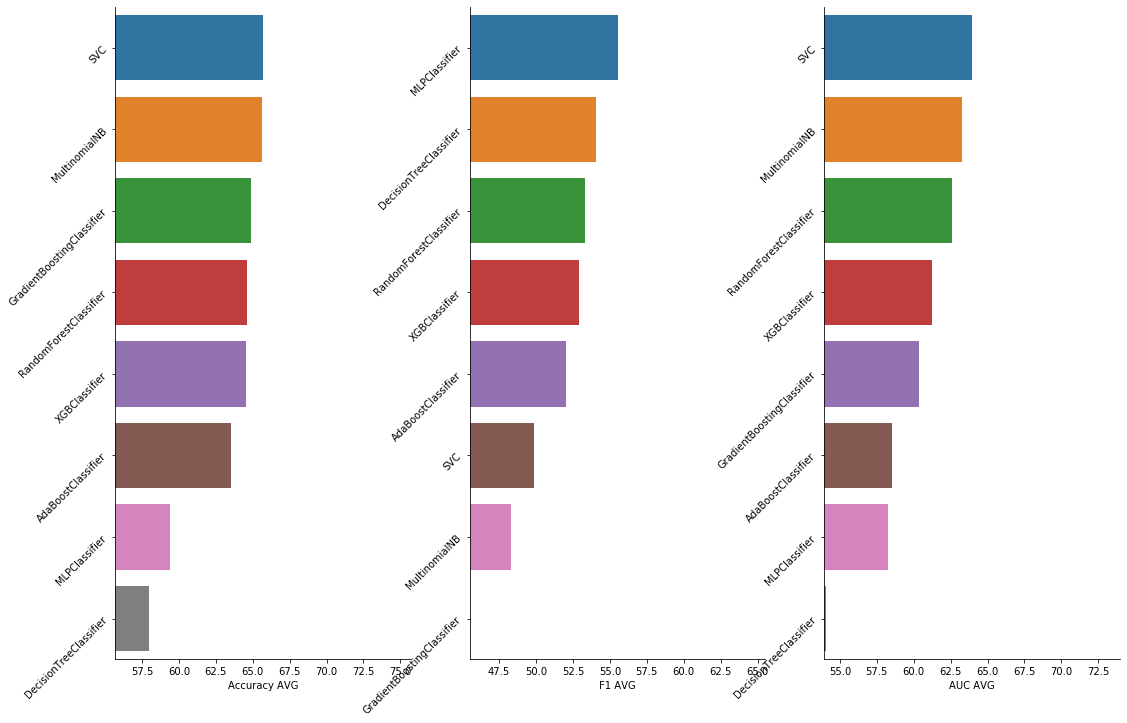

In [59]:
plot_metrics(sorted_acc_df, sorted_f1_df, sorted_auc_df)

In [60]:
# TfidfVectorizer Maximum nuber of features

max_features = 3000

# tf-idf vectorizer for sentence/topic/document modelling

tvec = TfidfVectorizer(max_features=max_features, ngram_range=(1, 3), max_df=0.65,
                       tokenizer=nltk.word_tokenize,
                       strip_accents='unicode',
                       lowercase=True, analyzer='word',
                       use_idf=True, smooth_idf=True, sublinear_tf=False,
                       stop_words=stopwords.words('english'))

# Fit & Transform on train texts
# Only transform on val & test texts

train_X = tvec.fit_transform(x_train).toarray()
valid_X = tvec.transform(x_val).toarray()
test_X = tvec.transform(x_test).toarray()

train_y = y_train
valid_y = y_val
test_y = y_test

/home/coderpriya/anaconda3/envs/PythonCPU/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [61]:
# Prepare training data

train_val_tf = np.append(train_X, valid_X, axis=0)
label_val_tf = np.append(train_y, valid_y, axis=0)

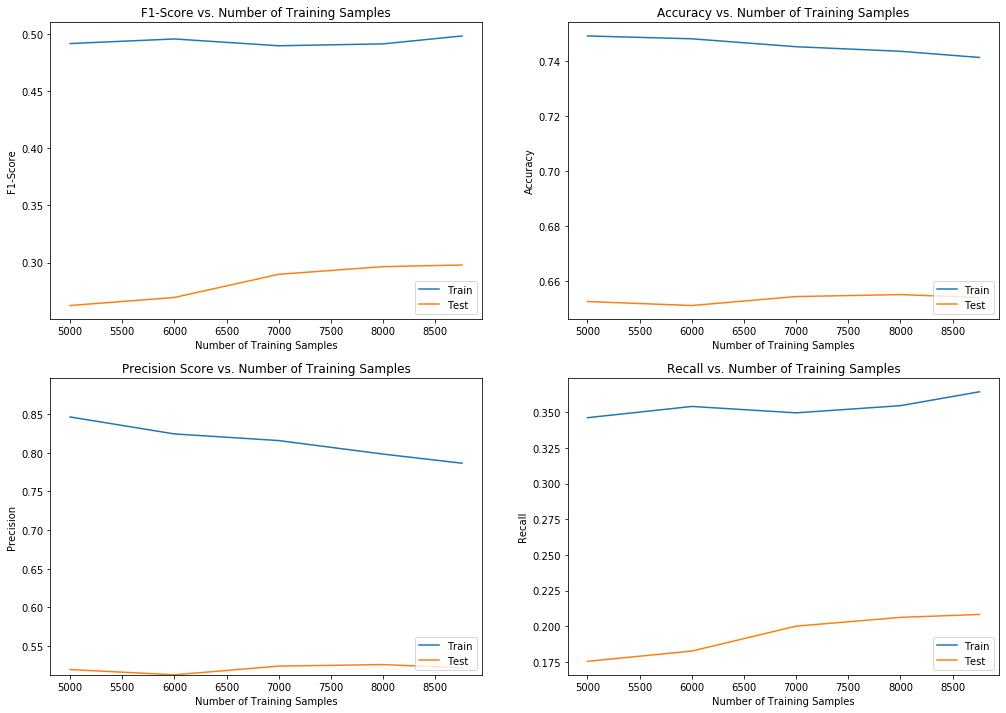

In [62]:
from sklearn.utils import shuffle

# Cross validation class instance initialization, validation using 5 splits on XGB classifier

cv = cross_validation(lr, train_val_tf, label_val_tf, n_splits=5,
                      init_chunk_size=5000, chunk_spacings=1000, average="binary")
cv.validate_for_holdout_set(test_X, y_test)

# Plot different scores
cv.plot_learning_curve()

In [63]:
# Model Optimization
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, rand, pyll
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample
import pprint

from scipy.stats.kde import gaussian_kde
# Parameter's space
hyper_space = {
    'alpha': hp.quniform('alpha',  0.05, 1, 0.05)
}

print('Sampling space example\n')
pprint.pprint(sample(hyper_space))

Sampling space example

{'alpha': 0.55}


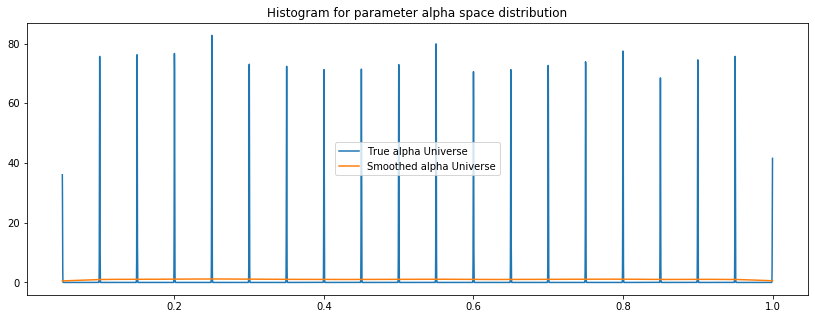

In [64]:
#Plot different parameter's space distribution after sampling for n_samples

n_samples = 5000
universe = {}

fig, axes = plt.subplots(nrows=len(hyper_space.keys()),
                         ncols=1, figsize=(14, 5))
cmap = plt.cm.jet

# Iterating over different trials & parameters
for param, param_space in hyper_space.items():

    # Sampling for n_samples
    universe[param] = [pyll.stochastic.sample(
        hyper_space[param]) for _ in range(n_samples)]
    param_domain = np.linspace(
        min(universe[param]), max(universe[param]), n_samples)

    # KDE calculation
    hist = gaussian_kde(universe[param], 0.001)
    axes.plot(param_domain, hist(param_domain),
              label='True {} Universe'.format(param))

    blurred_hist = gaussian_kde(universe[param], 0.1)
    axes.plot(param_domain, blurred_hist(param_domain),
              label='Smoothed {} Universe'.format(param))

    axes.set_title(
        'Histogram for parameter {} space distribution'.format(param))
    axes.legend(loc='best')

    del universe[param]

plt.show()


In [65]:
iterations = 50
random_state = 21
cores = -1
best = 0

# Define the XGB  function as the objective


def objective(space):

    global best

    train_val_tf_ = train_val_tf
    test_X_ = test_X

    # Normalizing or scaling the data
    if 'normalize' in space:
        if space['normalize'] == 1:
            train_val_tf_ = normalize(train_val_tf_)
            test_X_ = normalize(test_X_)
            del space['normalize']

    if 'scale' in space:
        if space['scale'] == 1:
            train_val_tf_ = scale(train_val_tf_)
            test_X_ = scale(test_X_)
            del space['scale']

    nb = MultinomialNB(alpha=space['alpha'])

    nb.fit(train_val_tf, label_val_tf)

    # Predict & evaluate metrics
    y_pred = nb.predict(test_X)

    # print('\nNaive Bayes Scores\n')
    # print("F1 score {:.4}%".format( f1_score(y_test, y_pred, average='macro')*100 ) )
    # print('Accuracy score {:.4}%'.format(accuracy_score(y_test, y_pred)*100) )

    # evaluate predictions
    predictions_prob = nb.predict_proba(test_X)[:, 1]
    auc = roc_auc_score(y_test, predictions_prob)

    if auc > best:
        best = auc
        print('\nBest AUC score: {}'.format(np.round(best*100, 2)))
        print('Space Parameters')
        pprint.pprint(space)

    return {'loss': 1-auc, 'status': STATUS_OK}


# Parameter's space
space = {
    'alpha': hp.quniform('alpha',  0.05, 1, 0.01)
}


print('Sampling space example')
pprint.pprint(sample(space))

# Trials keeps track of all experiments; These can be saved and loaded back into a new batch of experiments
tpe_auc_trials = Trials()

# The algorithm tpe.suggest runs the Tree-structured Parzen estimator
best_tpe_auc = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=iterations,
                    trials=tpe_auc_trials)

print('\n\nThe best parameteres discovered through HyperOpt tpe.suggest algorithm using AUC as an evaluation metric\n\n', best_tpe_auc)


Sampling space example
{'alpha': 0.59}
                                                      
Best AUC score: 63.74
Space Parameters                                      
{'alpha': 0.55}                                       
                                                                                
Best AUC score: 63.74
Space Parameters                                                                
{'alpha': 0.64}                                                                 
                                                                                
Best AUC score: 63.78
Space Parameters                                                              
{'alpha': 0.86}                                                               
                                                                                 
Best AUC score: 63.78
Space Parameters                                                                 
{'alpha': 0.91}                                               

In [66]:
# Train a MultinomialNB classifier

nb = MultinomialNB(alpha=0.5)
nb.fit(train_val_tf, label_val_tf)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

In [67]:
# Predict & evaluate metrics

y_pred = nb.predict(test_X)

print('Naive Bayes Scores\n')
print("F1 score {:.4}%".format(f1_score(y_test, y_pred, average='macro')*100))
print('Accuracy score {:.4}%'.format(accuracy_score(y_test, y_pred)*100))

Naive Bayes Scores

F1 score 53.37%
Accuracy score 64.9%



Accuracy score: 64.90%
Overall Train and Prediction time: 0.04s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




,false,true
false,1585,207
true,764,210




Saving Confusion Matrices in the ./save/con_matrix directory


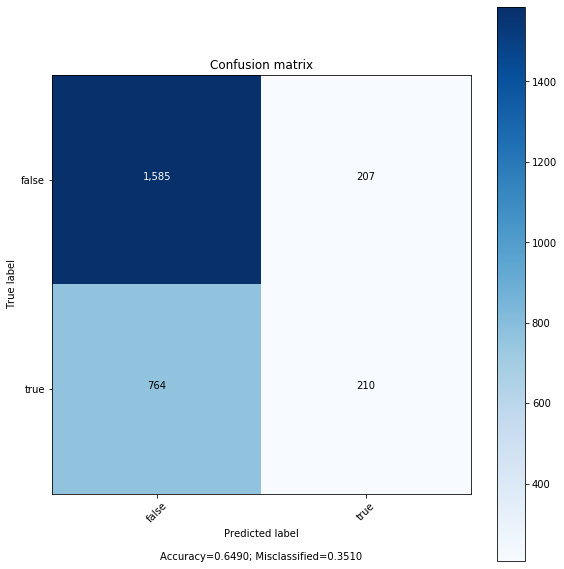


Classification Report

              precision    recall  f1-score   support

       false       0.67      0.88      0.77      1792
        true       0.50      0.22      0.30       974

    accuracy                           0.65      2766
   macro avg       0.59      0.55      0.53      2766
weighted avg       0.61      0.65      0.60      2766


 Plotting precision_recall curve against a given threshold of 0.6


Adjusted Threshold Confusion Matrix

      pred_neg  pred_pos
neg      1725        67
pos       896        78 




Adjusted Threshold F1 Score:  [0.7817811  0.13941019]


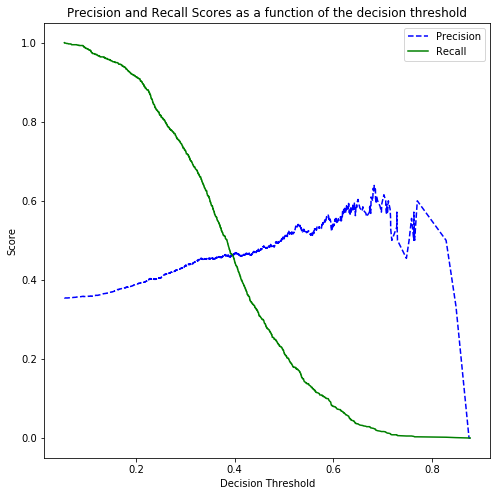

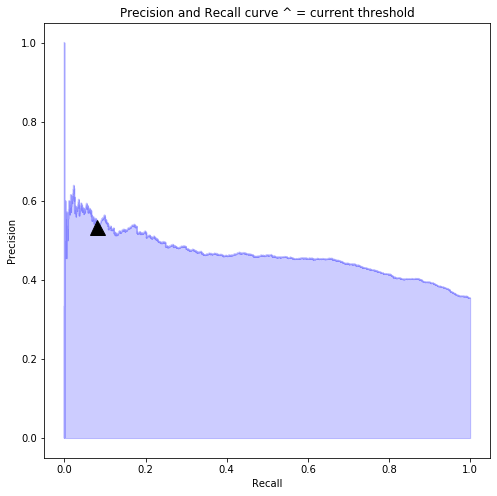

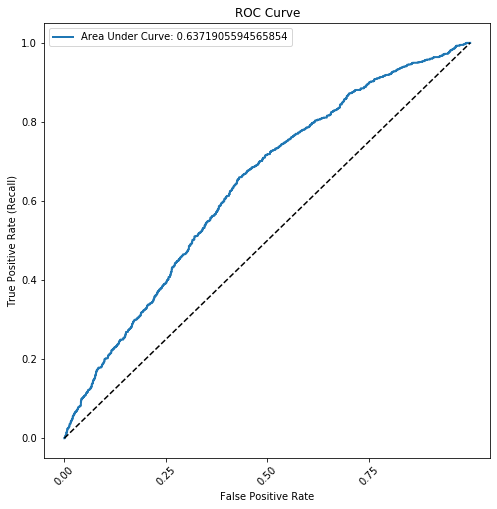

In [68]:
_, _, _, _ = metrics_fusion(nb, _, _, test_X, y_test, model_trained=True,
                            stats=True, precision_recall_stats=True, new_threshold=0.6)

In [69]:
# TfidfVectorizer Maximum nuber of features

max_features = 3000

# tf-idf vectorizer for sentence/topic/document modelling

tvec = TfidfVectorizer(max_features=max_features, ngram_range=(1, 3), max_df=0.65,
                       tokenizer=nltk.word_tokenize,
                       strip_accents='unicode',
                       lowercase=True, analyzer='word',
                       use_idf=True, smooth_idf=True, sublinear_tf=False,
                       stop_words=stopwords.words('english'))

# Fit & Transform on train texts
# Only transform on val & test texts

train_X = tvec.fit_transform(x_train).toarray()
valid_X = tvec.transform(x_val).toarray()
test_X = tvec.transform(x_test).toarray()

train_y = y_train
valid_y = y_val
test_y = y_test

/home/coderpriya/anaconda3/envs/PythonCPU/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [70]:
# Prepare training data

train_val_tf = np.append(train_X, valid_X, axis=0)
label_val_tf = np.append(train_y, valid_y, axis=0)

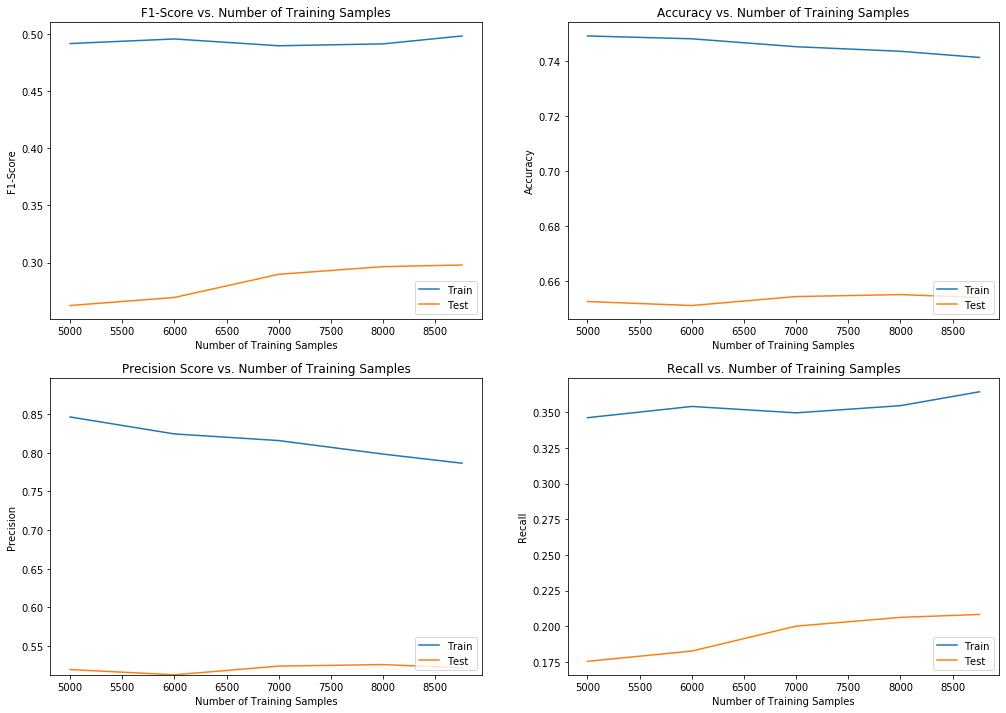

In [71]:
# Cross validation class instance initialization, validation using 5 splits on XGB classifier

cv = cross_validation(lr, train_val_tf, label_val_tf, n_splits=5,
                      init_chunk_size=5000, chunk_spacings=1000, average="binary")
cv.validate_for_holdout_set(test_X, y_test)

# Plot different scores
cv.plot_learning_curve()

In [72]:
# Parameter's space

hyper_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 200, 600, 1)),
    'eta': hp.quniform('eta', 0.025, 0.25, 0.025),
    'max_depth':  scope.int(hp.choice('max_depth', np.arange(1, 30, dtype=int))),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.quniform('subsample', 0.7, 1, 0.05)
}

print('Sampling space example\n')
pprint.pprint(sample(hyper_space))

Sampling space example

{'eta': 0.225,
 'max_depth': 11,
 'min_child_weight': 4.0,
 'n_estimators': 508,
 'subsample': 0.8500000000000001}


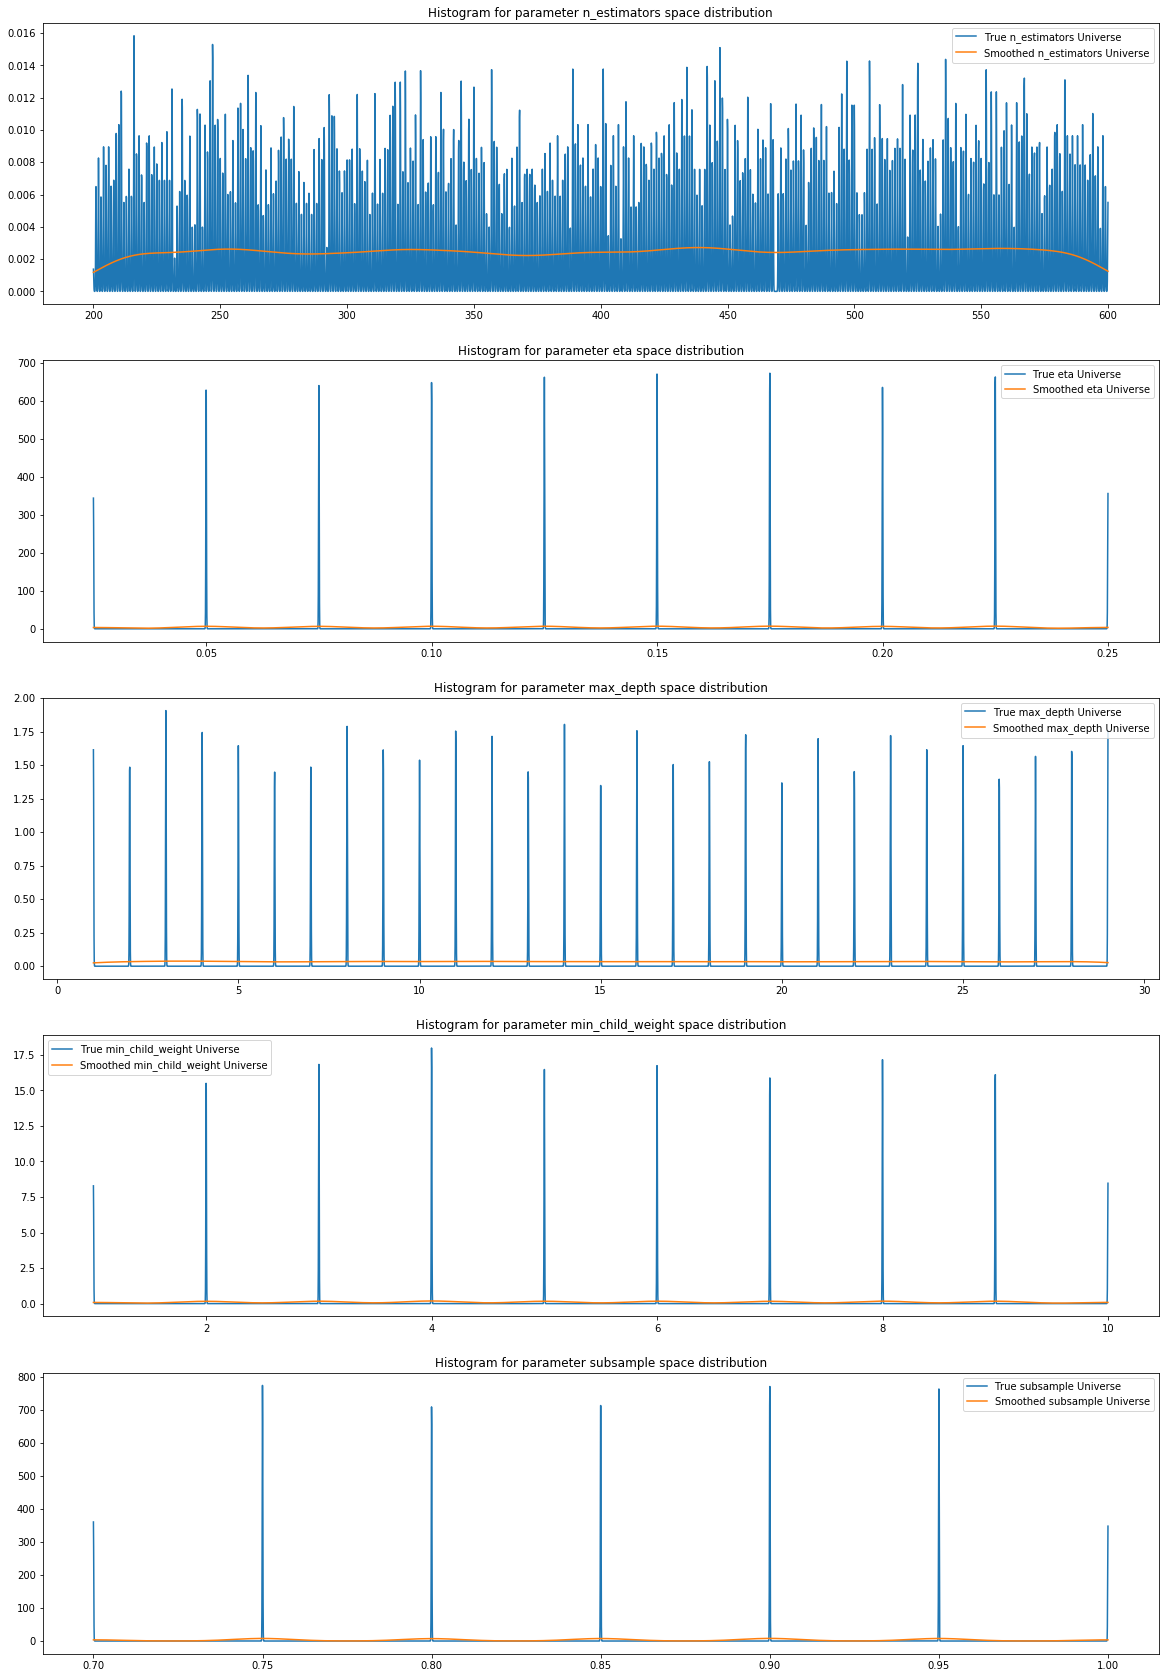

In [73]:
# Plot different parameter's space distribution after sampling for n_samples

n_samples = 5000
universe = {}

fig, axes = plt.subplots(nrows=len(hyper_space.keys()),
                         ncols=1, figsize=(20, 30))
cmap = plt.cm.jet

# Iterating over different trials & parameters
for index, (param, param_space) in enumerate(hyper_space.items()):

    # Sampling for n_samples
    universe[param] = [pyll.stochastic.sample(
        hyper_space[param]) for _ in range(n_samples)]
    param_domain = np.linspace(
        min(universe[param]), max(universe[param]), n_samples)

    # KDE calculation
    hist = gaussian_kde(universe[param], 0.001)
    axes[index].plot(param_domain, hist(param_domain),
                     label='True {} Universe'.format(param))

    blurred_hist = gaussian_kde(universe[param], 0.1)
    axes[index].plot(param_domain, blurred_hist(param_domain),
                     label='Smoothed {} Universe'.format(param))

    axes[index].set_title(
        'Histogram for parameter {} space distribution'.format(param))
    axes[index].legend()

plt.show()

In [74]:
iterations = 10
random_state = 21
cores = -1
best = 0

# Define the XGB  function as the objective


def objective(space):

    global best

    train_X_ = train_X
    valid_X_ = valid_X
    test_X_ = test_X

    # Normalizing or scaling the data
    if 'normalize' in space:
        if space['normalize'] == 1:
            train_X_ = normalize(train_X_)
            valid_X_ = normalize(valid_X_)
            test_X_ = normalize(test_X_)
            del space['normalize']

    if 'scale' in space:
        if space['scale'] == 1:
            train_X_ = scale(train_X_)
            valid_X_ = scale(valid_X_)
            test_X_ = scale(test_X_)
            del space['scale']

    eval_set = [(train_X, train_y), (valid_X, valid_y)]

    clf = XGBClassifier(n_estimators=space['n_estimators'],
                        learning_rate=space['eta'],
                        max_depth=space['max_depth'],
                        min_child_weight=space['min_child_weight'],
                        subsample=space['subsample'],
                        n_jobs=-1
                        )

    clf.fit(train_X, train_y,
            eval_set=eval_set, eval_metric="auc",
            # early_stopping_rounds=100,
            verbose=False)

    # evaluate predictions
    # predictions_prob = clf.predict_proba(test_X, ntree_limit=clf.best_iteration + 1)[:,1]
    predictions_prob = clf.predict_proba(test_X)[:, 1]
    auc = roc_auc_score(test_y, predictions_prob)

    if auc > best:
        best = auc
        print('\nBest AUC score: {}'.format(np.round(best*100, 2)))
        print('Space Parameters\n')
        pprint.pprint(space)

    return {'loss': 1-auc, 'status': STATUS_OK}


space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 10, 600, 50)),
    'eta': hp.quniform('eta', 0.025, 0.25, 0.025),
    'max_depth':  scope.int(hp.choice('max_depth', np.arange(1, 30, dtype=int))),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.quniform('subsample', 0.7, 1, 0.05),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
}


print('Sampling space example\n')
pprint.pprint(sample(space))

# Trials keeps track of all experiments; These can be saved and loaded back into a new batch of experiments
tpe_auc_trials = Trials()

# The algorithm tpe.suggest runs the Tree-structured Parzen estimator
best_tpe_auc = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=iterations,
                    trials=tpe_auc_trials)

print('\n\nThe best parameteres discovered through HyperOpt tpe.suggest algorithm using AUC as an evaluation metric\n\n', best_tpe_auc)

Sampling space example

{'eta': 0.05,
 'max_depth': 28,
 'min_child_weight': 10.0,
 'n_estimators': 550,
 'normalize': 1,
 'scale': 1,
 'subsample': 0.8500000000000001}
                                                      
Best AUC score: 58.27
Space Parameters                                      

{                                                     
'eta'                                                 
:                                                     
0.15000000000000002                                   
,                                                     
 
'max_depth'                                           
:                                                     
28                                                    
,                                                     
 
'min_child_weight'                                    
:                                                     
5.0                                                   
,                                 

In [75]:
# Train an XGB classifier

params = {'eta': 0.05,
          'max_depth': 10,
          'min_child_weight': 1.0,
          'n_estimators': 200,
          'normalize': 0,
          'scale': 0,
          'subsample': 0.75}

xgb = XGBClassifier(**params, n_jobs=-1, objective='binary:logistic',
                    random_state=21, seed=21, silent=True)
xgb.fit(train_val_tf, label_val_tf)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.05, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.0500000007, max_delta_step=0, max_depth=10,
              min_child_weight=1.0, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=-1, normalize=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=21, reg_alpha=0,
              reg_lambda=1, scale=0, scale_pos_weight=1, seed=21, silent=True,
              subsample=0.75, tree_method=None, ...)

In [76]:
# Predict & evaluate metrics

y_pred = xgb.predict(test_X)

print('XGBoost Scores\n')
print("F1 score {:.4}%".format(f1_score(y_test, y_pred, average='macro')*100))
print('Accuracy score {:.4}%'.format(accuracy_score(y_test, y_pred)*100))

XGBoost Scores

F1 score 52.49%
Accuracy score 65.87%



Accuracy score: 65.87%
Overall Train and Prediction time: 0.28s
-----------------------------------------------------------------------------------------


Confusion matrix of the Fake News test set




,false,true
false,1645,147
true,797,177




Saving Confusion Matrices in the ./save/con_matrix directory


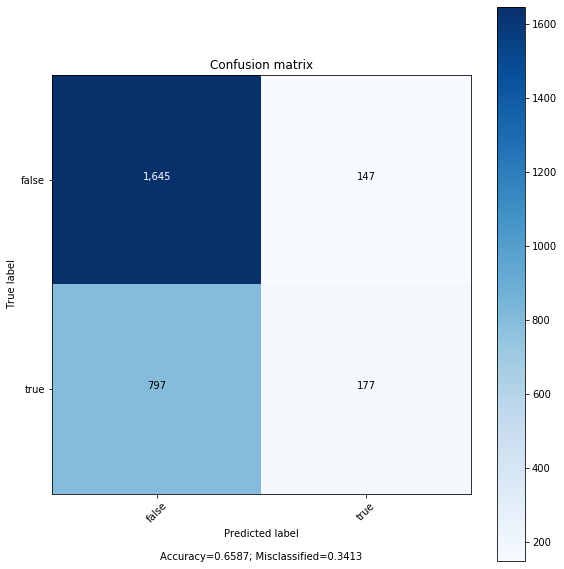


Classification Report

              precision    recall  f1-score   support

       false       0.67      0.92      0.78      1792
        true       0.55      0.18      0.27       974

    accuracy                           0.66      2766
   macro avg       0.61      0.55      0.52      2766
weighted avg       0.63      0.66      0.60      2766


 Plotting precision_recall curve against a given threshold of 0.55


Adjusted Threshold Confusion Matrix

      pred_neg  pred_pos
neg      1702        90
pos       871       103 




Adjusted Threshold F1 Score:  [0.77983963 0.17652099]


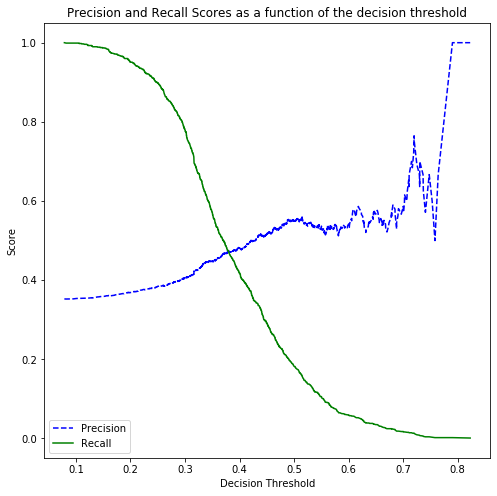

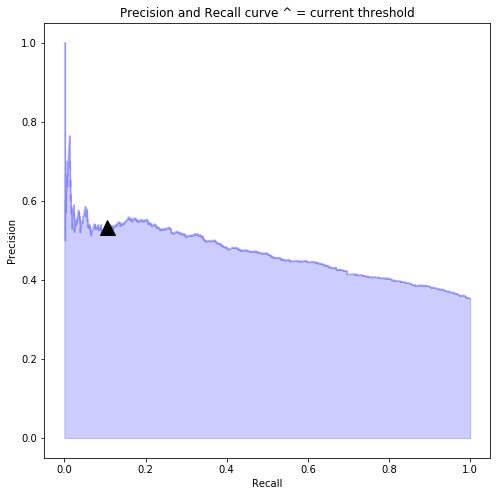

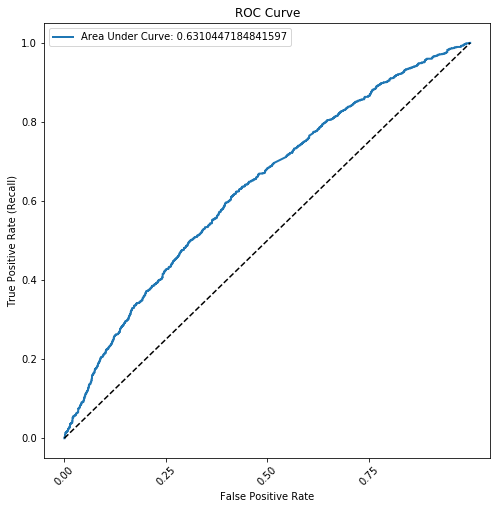

In [77]:
_, _, _, _ = metrics_fusion(xgb, _, _, test_X, y_test, model_trained=True,
                            stats=True, precision_recall_stats=True, new_threshold=0.55)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.77 µs

Validation result for Ensemble classifiers
VotingClassifier(estimators=[('svc',
                              SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='rbf', max_iter=-1,
                                  probability=True, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False)),
                             ('ada',
                              AdaBoostClassifier(algorithm='SAMME.R',
                                                 base_estimator=None,
                                                 learning_rate=1.0,
                                                 n_esti...
                                                     criterion='gini',
                                         

,false,true
false,1042,153
true,491,158




Saving Confusion Matrices in the ./save/con_matrix directory


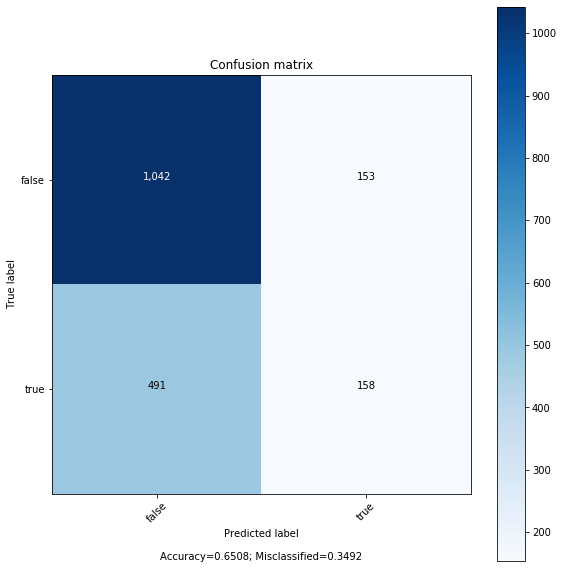


Classification Report

              precision    recall  f1-score   support

       false       0.68      0.87      0.76      1195
        true       0.51      0.24      0.33       649

    accuracy                           0.65      1844
   macro avg       0.59      0.56      0.55      1844
weighted avg       0.62      0.65      0.61      1844



In [82]:
%time
from sklearn.neighbors import KernelDensity, KNeighborsClassifier

# 9 Ensemble models

clf1 = SVC(probability=True)
clf2 = AdaBoostClassifier()
clf3 = MultinomialNB()
clf4 = XGBClassifier()
clf5 = GradientBoostingClassifier()
clf6 = MLPClassifier()
clf7 = KNeighborsClassifier(3)
clf8 = DecisionTreeClassifier()
clf9 = RandomForestClassifier()

eclf = VotingClassifier(estimators=[('svc', clf1), ('ada', clf2), ('mnb', clf3),
                                    ('xgb', clf4), ('gb', clf5), ('mlp', clf6),
                                    ('knn', clf7), ('dt', clf8), ('rf', clf9)], voting='soft', n_jobs=-1)

# for clf_name, clf in zip(["SVM", "AdaBoost", "Naive Bayes",
#                           "XGB Classifier", "GradientBoost", "Neural Net",
#                           "Nearest Neighbors", "Decision Tree", "Random Forest", 'Ensemble'],
#                          [clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, clf9, eclf]):

for clf_name, clf in zip(['Ensemble'], [eclf]):
    pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer(max_features=30000,
                                       stop_words=stopwords.words('english'), ngram_range=(1, 3))),
        ('classifier', clf)
    ])
    print("\nValidation result for {} classifiers".format(clf_name))
    print(clf)

    # Calculate accuracy & summmary
    clf_accuracy, clf_time, _, _ = metrics_fusion(
        pipeline, x_train, y_train, x_val, y_val, stats=True)


# Neural Networks

In [83]:
# Batch generator updated


def batch_generator_shuffle(train, label, batch_size):

    # Calculate no of batches
    number_of_batches = train.shape[0]/batch_size

    # Data set indices to choose a batch from
    batch = np.arange(tf_train.shape[0])
    # Shuffling batch indices
    np.random.shuffle(batch)

    # Starting batch index
    batch_idx = 0
    while True:
        # Selecting batches
        train_batch = train[batch[batch_size *
                                  batch_idx:batch_size*(batch_idx+1)], :].toarray()
        label_batch = label[batch[batch_size *
                                  batch_idx:batch_size*(batch_idx+1)]]

        #print('\n{} Batch indices from {} to {} selected.\n'.format((batch_idx+1), (batch_size*batch_idx), (batch_size*(batch_idx+1))))

        # Generator statement
        yield train_batch, label_batch

        # Next batch
        batch_idx += 1
        # Check if 1 epoch is finished then next batch index should be greater than no of batches
        if (batch_idx > number_of_batches):
            np.random.shuffle(batch)
            batch_idx = 0

In [85]:
# PrefrocCallback class implementing Callbacks
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard, Callback, CSVLogger

class PrefrocCallback(Callback):

    def __init__(self, training_data, validation_data):

        # Train & Validation data

        self.x_train = training_data[0]
        self.y_train = training_data[1]

        self.x_val = validation_data[0]
        self.y_val = validation_data[1]

    def on_train_begin(self, logs={}):

        # List to store Precison, Recall, F1 & ROC scores

        self.train_f1s = []
        self.train_recalls = []
        self.train_precisions = []
        self.train_rocs = []

        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        self.val_rocs = []

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):

        # Train set scores

        # Predicton, Target
        train_predict = (np.asarray(self.model.predict(self.x_train))).round()
        train_targ = self.y_train

        # Precison, Recall, F1 & ROC Score
        _train_f1 = f1_score(train_targ, train_predict)
        _train_recall = recall_score(train_targ, train_predict)
        _train_precision = precision_score(train_targ, train_predict)
        _train_roc = roc_auc_score(train_targ, train_predict)

        logs['train_f1'] = _train_f1
        logs['train_recall'] = _train_recall
        logs['train_precision'] = _train_precision
        logs['train_roc'] = _train_roc

        self.train_f1s.append(_train_f1)
        self.train_recalls.append(_train_recall)
        self.train_precisions.append(_train_precision)
        self.train_rocs.append(_train_roc)

        # Validation set scores

        # Predicton, Target
        val_predict = (np.asarray(self.model.predict(self.x_val))).round()
        val_targ = self.y_val

        # Precison, Recall, F1 & ROC Score
        _val_f1 = f1_score(val_targ, val_predict, average='weighted')
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        _val_roc = roc_auc_score(val_targ, val_predict)

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        logs['val_roc'] = _val_roc

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        self.val_rocs.append(_val_roc)

        # Display all the metrics
        print('\ntrain_precision: {:.4f} train_recall: {:.4f} train_f1: {:.4f} train_roc: {:.4f}'.format(
            _train_f1, _train_precision, _train_recall, _train_roc))
        print('val_precision: {:.4f} val_recall: {:.4f} val_f1: {:.4f} val_roc: {:.4f}\n'.format(
            _val_f1, _val_precision, _val_recall, _val_roc))

        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [86]:
# Checking labels, predictions shape


def check_units(y_true, y_pred):

    if (y_pred.shape[1] != 1):
        y_pred = y_pred[:, 1:2]
        y_true = y_true[:, 1:2]

    return y_true, y_pred


# Calculate Precision

def precision(y_true, y_pred):

    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    return precision


# Calculate Recall

def recall(y_true, y_pred):

    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())

    return recall


# Calculate F1 Score

def f1(y_true, y_pred):

    # Calculate Recall

    def recall(y_true, y_pred):

        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())

        return recall

    # Calculate Precision

    def precision(y_true, y_pred):

        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())

        return precision

    y_true, y_pred = check_units(y_true, y_pred)
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Basic LSTM

LSTMs using TF-IDF input vectors with Dense network.

In [93]:
%time
from sklearn.externals import joblib

# Splitting data into train, test & validation sets

x_train, x_val_test, y_train, y_val_test = train_test_split(
    train, label_encoded, test_size=.4, stratify=label_encoded, random_state=seed)

x_val, x_test, y_val, y_test = train_test_split(
    x_val_test, y_val_test, test_size=.6, stratify=y_val_test, random_state=seed)


# tf-idf vectorizer for sentence/topic/document modelling

tvec = TfidfVectorizer(max_features=max_features, ngram_range=(1, 3), max_df=0.65,
                       tokenizer=nltk.word_tokenize,
                       strip_accents='unicode',
                       lowercase=True, analyzer='word', token_pattern=r'\w+',
                       use_idf=True, smooth_idf=True, sublinear_tf=False,
                       stop_words=stopwords.words('german'))


# Fit & Transform on train texts
# Only transform on val & test texts

x_train_tf = tvec.fit_transform(x_train).toarray()
x_val_tf = tvec.transform(x_val).toarray()
x_test_tf = tvec.transform(x_test).toarray()

# Dumping tokenizer using joblib which is faster than pickle

print('\nDumping News TfidfVectorizer as tvec-dense ...')
#joblib.dump(tvec, os.path.join('./save/pickle', 'tvec-dense.pickle'))


# Printing the shape of different text corpus

print('\nx_train_tf shape: ', x_train_tf.shape)
print('x_val_tf: ', x_val_tf.shape)
print('x_test_tf: ', x_test_tf.shape)

# Reshape data to [samples, time steps, features] shape

print(
    '\nReshaping data to the shape [samples, time steps, features] for LSTMs ...')
x_train_tf_lstm = np.reshape(
    x_train_tf, (x_train_tf.shape[0], 1, x_train_tf.shape[1]))
x_val_tf_lstm = np.reshape(x_val_tf, (x_val_tf.shape[0], 1, x_val_tf.shape[1]))
x_test_tf_lstm = np.reshape(
    x_test_tf, (x_test_tf.shape[0], 1, x_test_tf.shape[1]))
print('\nReshaping done ...')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.25 µs


/home/coderpriya/anaconda3/envs/PythonCPU/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['fur', 'konnen', 'konnte', 'uber', 'wahrend', 'wurde', 'wurden'] not in stop_words.
  'stop_words.' % sorted(inconsistent))



Dumping News TfidfVectorizer as tvec-dense ...

x_train_tf shape:  (6914, 3000)
x_val_tf:  (1844, 3000)
x_test_tf:  (2766, 3000)

Reshaping data to the shape [samples, time steps, features] for LSTMs ...

Reshaping done ...


In [98]:
from keras.models import Model, Sequential, model_from_json, load_model
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, BatchNormalization
epochs = 3
%time

# Setting Checkpoint, Early Stopping, Precison, Recall, F1 & ROC Score callbacks

# The PrefrocCallback prints out metrices at the end of each epoch. It must be listed
# before the EarlyStopping callback, which monitors val_f1 values saved in the previous callback.

prefroc_callback = PrefrocCallback(training_data=(
    x_train_tf_lstm, y_train), validation_data=(x_val_tf_lstm, y_val))

early_stop = EarlyStopping(monitor='val_f1', patience=5, mode='max', verbose=1)

# checkpoint_path = './checkpoint/model_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5'
checkpoint_path = './checkpoint/model_best_weights.{epoch:02d}.hdf5'
checkpoint = ModelCheckpoint(
    checkpoint_path, monitor='val_f1', verbose=1, save_best_only=True, mode='max')

csv_logger = CSVLogger(
    './logs/csv/model_best_weights.{epoch:02d}.log', separator=',', append=False)

tensorboard = TensorBoard(
    log_dir='./logs', histogram_freq=2000, write_graph=True, write_images=False)

callbacks_list = [checkpoint, early_stop,
                  prefroc_callback, csv_logger, tensorboard]


np.random.seed(seed)

# Create Model

model = Sequential()

model.add(LSTM(512, input_shape=(1, max_features),
               dropout=0.2, recurrent_dropout=0.2))
model.add(BatchNormalization())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(1, activation='sigmoid'))

# Compile Model

model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Fit the model with shuffled data

# model.fit_generator(generator=batch_generator_shuffle(x_train_tf, y_train, batch_size),
#                     validation_data=(x_val_tf, y_val), epochs=50, steps_per_epoch=x_train_tf.shape[0]/batch_size,
#                     verbose=2, callbacks=callbacks_list, shuffle=True, initial_epoch=0,
#                     use_multiprocessing=True)

model.fit(x_train_tf_lstm, y_train, validation_data=(x_val_tf_lstm, y_val), batch_size=batch_size,
          epochs=epochs, verbose=2)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.34 µs
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 512)               7194624   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_8 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                32832     
________________________________________________________

In [142]:
model.history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'val_f1', 'val_precision', 'val_recall', 'loss', 'accuracy', 'f1', 'precision', 'recall'])

In [143]:
# Evaluation gives the result from the last trained model

y_pred = model.predict(x=x_test_tf_lstm)
y_pred = [np.round(value) for value in y_pred]

print('LSTM basic cells Scores\n')
print("F1 score {:.4}%".format(f1_score(y_test, y_pred)*100))
print('Accuracy score {:.4}%'.format(accuracy_score(y_test, y_pred)*100))


con_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn heatmap

fig, ax = plt.subplots(1, figsize=(8, 8))

ax = sns.heatmap(con_matrix, ax=ax, cmap='viridis', annot=True, fmt='g')

ax.set_xticklabels(list(le.classes_), rotation=45)
ax.set_yticklabels(list(le.classes_), rotation=45)

plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion Matrix')

#fig.savefig(os.path.join('./save/con_matrix','FakeNews_LSTM_Confusion_Matrix.png'), dpi=300)
plt.show()

ValueError: Error when checking input: expected embedding_6_input to have 2 dimensions, but got array with shape (2766, 1, 3000)

LSTM with Embeddings
LSTMs with embeddings learned from the corpus of Fake News.

In [102]:
#Parameters
vocab_size = 300
maxlen = 300
batch_size = 32
embedding_type = 'embed_tokenizer'

seed = 21
np.random.seed(seed)

In [103]:
# Load Data
%time

# Splitting data into train, test & validation sets
x_train, x_val_test, y_train, y_val_test = train_test_split(
    train, label_onehot, test_size=.4, stratify=label_encoded, random_state=seed)

x_val, x_test, y_val, y_test = train_test_split(
    x_val_test, y_val_test, test_size=.6, stratify=y_val_test, random_state=seed)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10 µs


In [111]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras import backend as K

# Create the tokenizer & fit on all the url texts

tokenizer = Tokenizer(num_words=vocab_size, lower=True)
tokenizer.fit_on_texts(x_train)

# Dumping tokenizer using joblib which is faster than pickle
#joblib.dump(tokenizer, os.path.join('./save/pickle','{}/tokenizer.pickle'.format(embedding_type)))

# Generating sequences & padding for efficient training of our neural network
# Transforms each text in texts to a sequence of integers.
train_sequences = tokenizer.texts_to_sequences(x_train)
train_padded_sequences = sequence.pad_sequences(train_sequences, maxlen=maxlen)

val_sequences = tokenizer.texts_to_sequences(x_val)
val_padded_sequences = sequence.pad_sequences(val_sequences, maxlen=maxlen)

test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded_sequences = sequence.pad_sequences(test_sequences, maxlen=maxlen)


# Initializing & running keras model

print('\n\n****************** Keras model training started. *******************\n\n')

# Setting checkpoint & early stopping
#checkpoint_path = os.path.join(os.path.join('./checkpoint', embedding_type),'model_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5')
checkpoint = ModelCheckpoint(
    checkpoint_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stop = EarlyStopping(monitor='val_acc', patience=5, mode='max')

# prefroc_callback = PrefrocCallback(training_data=(train_padded_sequences, y_train), validation_data=(val_padded_sequences, y_val))

tensorboard = TensorBoard(
    log_dir='./logs', histogram_freq=2000, write_graph=True, write_images=False)

callbacks_list = [checkpoint, tensorboard]

# Running the pipeline
# Fixing the seed again
np.random.seed(seed)

print('\n\nBuild model ...')
model = Sequential()
model.add(Embedding(vocab_size, 300, input_length=maxlen))
model.add(LSTM(300, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))

# try using different optimizers and different optimizer configs

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1, precision, recall])

print(model.summary())

print('Training starts...')
model.fit(train_padded_sequences, y_train,
          batch_size=batch_size,
          epochs=5,
          validation_data=(val_padded_sequences, y_val),
          verbose=2)




****************** Keras model training started. *******************




Build model ...
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 300, 300)          90000     
_________________________________________________________________
lstm_7 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 602       
Total params: 811,802
Trainable params: 811,802
Non-trainable params: 0
_________________________________________________________________
None
Training starts...


/home/coderpriya/anaconda3/envs/PythonCPU/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6914 samples, validate on 1844 samples
Epoch 1/5
 - 412s - loss: 0.6413 - accuracy: 0.6482 - f1: 0.1044 - precision: 0.2787 - recall: 0.0730 - val_loss: 0.6349 - val_accuracy: 0.6589 - val_f1: 0.1884 - val_precision: 0.5236 - val_recall: 0.1222
Epoch 2/5
 - 390s - loss: 0.6204 - accuracy: 0.6592 - f1: 0.2477 - precision: 0.5600 - recall: 0.1747 - val_loss: 0.6267 - val_accuracy: 0.6573 - val_f1: 0.1914 - val_precision: 0.5537 - val_recall: 0.1226
Epoch 3/5
 - 371s - loss: 0.6075 - accuracy: 0.6710 - f1: 0.3410 - precision: 0.5828 - recall: 0.2646 - val_loss: 0.6287 - val_accuracy: 0.6567 - val_f1: 0.3074 - val_precision: 0.5241 - val_recall: 0.2337
Epoch 4/5
 - 359s - loss: 0.5974 - accuracy: 0.6782 - f1: 0.3784 - precision: 0.5822 - recall: 0.3012 - val_loss: 0.6369 - val_accuracy: 0.6524 - val_f1: 0.3487 - val_precision: 0.5199 - val_recall: 0.2779
Epoch 5/5
 - 330s - loss: 0.5873 - accuracy: 0.6827 - f1: 0.4101 - precision: 0.5904 - recall: 0.3385 - val_loss: 0.6444 - val_a

In [112]:
# Evaluate the model

scores = model.evaluate(test_padded_sequences, y_test,
                        batch_size=batch_size)
print('Loss:', scores[0])
print('Accuracy:', scores[1])

2766/2766 [==============================] - 23s 8ms/step
Loss: 0.6607146076292382
Accuracy: 0.6178597211837769


In [113]:
# LSTM with pre-trained GloVe Embeddings¶
vocab_size = 300
maxlen = 300
batch_size = 32
epochs = 10
embedding_type = 'glove_embed_tokenizer'

seed = 21
np.random.seed(seed)

In [136]:
%time

# Splitting data into train, test & validation sets
x_train, x_val_test, y_train, y_val_test = train_test_split(
    train, label_onehot, test_size=.4, stratify=label_encoded, random_state=seed)

x_val, x_test, y_val, y_test = train_test_split(
    x_val_test, y_val_test, test_size=.6, stratify=y_val_test, random_state=seed)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 26.9 µs


In [137]:
# Create the tokenizer & fit on all the url texts

tokenizer = Tokenizer(num_words=vocab_size, lower=True)
tokenizer.fit_on_texts(x_train)

# Dumping tokenizer using joblib which is faster than pickle
#joblib.dump(tokenizer, os.path.join('./save/pickle','{}/tokenizer.pickle'.format(embedding_type)))

# Generating sequences & padding for efficient training of our neural network
# Transforms each text in texts to a sequence of integers.
train_sequences = tokenizer.texts_to_sequences(x_train)
train_padded_sequences = sequence.pad_sequences(train_sequences, maxlen=maxlen)

val_sequences = tokenizer.texts_to_sequences(x_val)
val_padded_sequences = sequence.pad_sequences(val_sequences, maxlen=maxlen)

test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded_sequences = sequence.pad_sequences(test_sequences, maxlen=maxlen)

del x_train, train_sequences, x_val, val_sequences, x_test, test_sequences

words = []

# Load Glove embeddings

print('Loading Glove word vectors ...')
embeddings_index = dict()

try:
    f = open('/home/coderpriya/Desktop/ResearchDataset/glove.6B.100d.txt',encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        words.append(word)
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
except Exception as e:
    print('Stacktrace', e)
    print('Glove file does not exist.')
finally:
    f.close()

print('Loaded %s Glove word vectors.' % len(embeddings_index))


# Create a weight matrix for all the words

print('\nMapping words to Glove embeddings ...')
embedding_matrix = np.zeros((vocab_size, maxlen))
print('Shape of Embedding Matrix: ', embedding_matrix.shape)

for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        print('Shape of Embedding Matrix: ', embedding_vector.shape)
        paddingCount = embedding_matrix[index].shape[0] - embedding_vector.shape[0]
        embedding_vector = np.pad(embedding_vector, (0, paddingCount), 'constant')
        print('Shape of Embedding Matrix: ', embedding_vector.shape)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

print('Shape of Embedding Matrix: ', embedding_matrix.shape)
print('Glove Mapping done.')

Loading Glove word vectors ...
Loaded 400000 Glove word vectors.

Mapping words to Glove embeddings ...
Shape of Embedding Matrix:  (300, 300)
Shape of Embedding Matrix:  (100,)
Shape of Embedding Matrix:  (300,)
Shape of Embedding Matrix:  (100,)
Shape of Embedding Matrix:  (300,)
Shape of Embedding Matrix:  (100,)
Shape of Embedding Matrix:  (300,)
Shape of Embedding Matrix:  (100,)
Shape of Embedding Matrix:  (300,)
Shape of Embedding Matrix:  (100,)
Shape of Embedding Matrix:  (300,)
Shape of Embedding Matrix:  (100,)
Shape of Embedding Matrix:  (300,)
Shape of Embedding Matrix:  (100,)
Shape of Embedding Matrix:  (300,)
Shape of Embedding Matrix:  (100,)
Shape of Embedding Matrix:  (300,)
Shape of Embedding Matrix:  (100,)
Shape of Embedding Matrix:  (300,)
Shape of Embedding Matrix:  (100,)
Shape of Embedding Matrix:  (300,)
Shape of Embedding Matrix:  (100,)
Shape of Embedding Matrix:  (300,)
Shape of Embedding Matrix:  (100,)
Shape of Embedding Matrix:  (300,)
Shape of Embeddin

In [138]:
# Initializing & running keras model
epochs = 5
print('\n\n****************** Keras model training started. *******************\n\n')

# Setting checkpoint & early stopping
#checkpoint_path = os.path.join(os.path.join('./checkpoint', embedding_type), 'model_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5')
#checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stop = EarlyStopping(monitor='val_acc', patience=5, mode='max')

# prefroc_callback = PrefrocCallback(training_data=(train_padded_sequences, y_train), validation_data=(val_padded_sequences, y_val))

tensorboard = TensorBoard(
    log_dir='./logs', histogram_freq=2000, write_graph=True, write_images=False)

#callbacks_list = [checkpoint, tensorboard]

# Running the pipeline
# Fixing the seed again
np.random.seed(seed)

print('\n\nBuild model ...')
model = Sequential()
model.add(Embedding(vocab_size, 300, input_length=maxlen,
                    weights=[embedding_matrix], trainable=False))
model.add(LSTM(maxlen, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))

# try using different optimizers and different optimizer configs

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1, precision, recall])

print(model.summary())

print('Training starts...')
model.fit(train_padded_sequences, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(val_padded_sequences, y_val),
          verbose=2)



****************** Keras model training started. *******************




Build model ...
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 300, 300)          90000     
_________________________________________________________________
lstm_9 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 602       
Total params: 811,802
Trainable params: 721,802
Non-trainable params: 90,000
_________________________________________________________________
None
Training starts...
Train on 6914 samples, validate on 1844 samples
Epoch 1/5
 - 323s - loss: 0.6480 - accuracy: 0.6349 - f1: 0.0969 - precision: 0.2690 - recall: 0.0737 - val_loss: 0.6383 - val_accuracy: 0.6459 - val_f1: 0.1716 - val_precision: 0.4155 - val_recall: 0.1148
Epo

In [139]:
# Evaluate the model

scores = model.evaluate(test_padded_sequences, y_test,
                        batch_size=batch_size)
print('Loss:', scores[0])
print('Accuracy:', scores[1])

2766/2766 [==============================] - 25s 9ms/step
Loss: 0.6409676312452111
Accuracy: 0.6428055167198181


In [140]:
from sklearn.manifold import TSNE

#Creating the tsne plot

tsne = TSNE(perplexity=30.0, n_components=2, init='pca', n_iter=500)
low_dim_embedding = tsne.fit_transform(embedding_matrix)

# Finally plotting and saving the fig
plot_with_labels(low_dim_embedding, words)

AssertionError: More labels than embeddings